In [1]:
import os
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import folium
import matplotlib.pyplot as plt
from pathlib import Path
from sys import exit
import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
import folium.plugins as foplug
from folium.plugins import BeautifyIcon

import torch
from kmeans_pytorch import kmeans, kmeans_predict

import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import plotly.express as px
import plotly.graph_objects as go
import graphviz

import shap

plt.rcParams.update({'font.size': 22})

In [2]:
def removePrefix(text, prefix):
    
    if len(prefix) == 0:
        return text
    
    if text.startswith(prefix):
        text = text[len(prefix):]
    
    return text

def removeSuffix(text, suffix):
    
    if len(suffix) == 0:
        return text
    
    if text.endswith(suffix):
        text = text[:-len(suffix)]
    
    return text

def getCoordinateFromText(name_text, file_prefix, file_suffix):
    try:
        name_text = removePrefix(name_text, file_prefix)
        name_text = removeSuffix(name_text, file_suffix)
        lat, lon = name_text.split('_')
    except:
        print(name_text)
    
    return [float(lat), float(lon)]

def getCoordinatesFromFileNames(file_names, file_prefix, file_suffix):
    
    coord = []
    for file in file_names:
        # print(file)
        try:
            file = removePrefix(file, file_prefix)
            file = removeSuffix(file, file_suffix)
            lat, lon = file.split('_')
            coord.append([float(lon), float(lat)])
        except:
            print(file)
    
    return coord

In [3]:
def correlation_matrix(df: pd.DataFrame):
    """
    A function to calculate and plot
    correlation matrix of a DataFrame.
    """
    # Create the matrix
    matrix = df.corr()
    
    # Create cmap
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
    # Create a mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Make figsize bigger
    fig, ax = plt.subplots(figsize=(16,12))
    
    # Plot the matrix
    _ = sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, ax=ax)

def identify_correlated(df, threshold):
    """
    A function to identify highly correlated features.
    """
    # Compute correlation matrix with absolute values
    matrix = df.corr().abs()
    
    # Create a boolean mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Subset the matrix
    reduced_matrix = matrix.mask(mask)
    
    # Find cols that meet the threshold
    to_drop = [c for c in reduced_matrix.columns if any(reduced_matrix[c] > threshold)]
    
    return to_drop

def get_correlated_factors(df, threshold):
    matrix = df.corr().abs()
    np.fill_diagonal(matrix.values, 0)
    
    corr_factors = {}
    for col in matrix.columns:
        corr_factors[col] = matrix[matrix[col] > threshold][col]
    
    return corr_factors

In [4]:
def decision_tree_fitting(X, y, criterion, splitter, mdepth, clweight, minleaf):

    # Create training and testing samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Fit the model
    model = tree.DecisionTreeClassifier(criterion=criterion, 
                                        splitter=splitter, 
                                        max_depth=mdepth,
                                        class_weight=clweight,
                                        min_samples_leaf=minleaf, 
                                        random_state=0, 
                                  )
    clf = model.fit(X_train, y_train)

    # Predict class labels on training data
    pred_labels_tr = model.predict(X_train)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)

    # Tree summary and model evaluation metrics
    print('*************** Tree Summary ***************')
    print('Classes: ', clf.classes_)
    print('Tree Depth: ', clf.tree_.max_depth)
    print('No. of leaves: ', clf.tree_.n_leaves)
    print('No. of features: ', clf.n_features_in_)
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Test Data ***************')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')
    
    # Use graphviz to plot the tree
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X.columns,
                                filled=True, 
                                rounded=True, 
                                #rotate=True,
                               ) 
    graph = graphviz.Source(dot_data)
    
    # Return relevant data for chart plotting
    return X_train, X_test, y_train, y_test, clf, graph

def random_forest_fitting(X, y, crit, bootstrap, max_feat, max_depth, min_leaf, n_est):

    # Create training and testing samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Fit the model
    model = RandomForestClassifier(criterion=crit, bootstrap=bootstrap, max_features=max_feat,
                                    max_depth=max_depth, min_samples_leaf=min_leaf, n_estimators=n_est,
                                   random_state=0)
    
    clf = model.fit(X_train, y_train)

    # Predict class labels on training data
    pred_labels_tr = model.predict(X_train)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)

    # Tree summary and model evaluation metrics
    print('*************** Model Summary ***************')
    print('Classes: ', clf.classes_)
    print('No. of outputs: ', clf.n_outputs_)
    print('No. of features: ', clf.n_features_in_)
    print('No. of estimators: ', len(clf.estimators_))
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Test Data ***************')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')
    
    
    # Return relevant data for chart plotting
    return X_train, X_test, y_train, y_test, clf

## Vary Temp and Prec
- 2-dimensional target data (fq,snow)
- 5 temp points x 5 prec points = 25 data points for each grid

In [6]:
# Read all the files
results_dir = "../results/w2_oct_22/"

file_suffix = "historical_snowmelt_tracker.csv"

fqsnow_df = pd.DataFrame()

file_path = results_dir + "run0_"+file_suffix
fqsnow_df_single = pd.read_csv(file_path,index_col=1)

fqsnow_df['cell'] = fqsnow_df_single.index
fqsnow_df.set_index('cell', inplace=True)

fqsnow_df_single['run0'] = fqsnow_df_single.numerator / fqsnow_df_single.denominator
fqsnow_df = fqsnow_df.merge(fqsnow_df_single['run0'], how='outer', left_index=True, right_index=True)

for i in range(1,25):
    run_id = "run"+str(i)
    file_path = results_dir + run_id+ "_"+file_suffix
    fqsnow_df_single = pd.read_csv(file_path,index_col=1)
    fqsnow_df_single[run_id] = fqsnow_df_single.numerator / fqsnow_df_single.denominator
    fqsnow_df = fqsnow_df.merge(fqsnow_df_single[run_id], how='outer', left_index=True, right_index=True)

fqsnow_df

run0      run1      run2  \
cell                                                                    
fluxes_vic_cropsyst_45.21875_-121.71875  0.563788  0.570220  0.576664   
fluxes_vic_cropsyst_45.21875_-121.78125  0.543189  0.547984  0.553995   
fluxes_vic_cropsyst_45.21875_-121.84375  0.491789  0.502254  0.507870   
fluxes_vic_cropsyst_45.21875_-121.90625  0.434120  0.438955  0.443761   
fluxes_vic_cropsyst_45.21875_-121.96875  0.429765  0.452721  0.467205   
...                                           ...       ...       ...   
fluxes_vic_cropsyst_48.71875_-117.84375  0.393723  0.396305  0.403243   
fluxes_vic_cropsyst_48.71875_-117.90625  0.424294  0.373993  0.359459   
fluxes_vic_cropsyst_48.71875_-118.78125  0.482238  0.486106  0.484468   
fluxes_vic_cropsyst_48.71875_-118.84375  0.501811  0.522548  0.543546   
fluxes_vic_cropsyst_48.71875_-118.90625  0.495429  0.471021  0.462494   

                                             run3      run4      run5  \
cell                                                                    
fluxes_vic_cropsyst_45.21875_-121.71875  0.581325  0.585073  0.517927   
fluxes_vic_cropsyst_45.21875_-121.78125  0.557254  0.560944  0.500714   
fluxes_vic_cropsyst_45.21875_-121.84375  0.512750  0.518116  0.446515   
fluxes_vic_cropsyst_45.21875_-121.90625  0.447913  0.451492  0.383843   
fluxes_vic_cropsyst_45.21875_-121.96875  0.476580  0.484097  0.380857   
...                                           ...       ...       ...   
fluxes_vic_cropsyst_48.71875_-117.84375  0.410257  0.414967  0.378891   
fluxes_vic_cropsyst_48.71875_-117.90625  0.356818  0.359657  0.413882   
fluxes_vic_cropsyst_48.71875_-118.78125  0.482588  0.481789  0.457181   
fluxes_vic_cropsyst_48.71875_-118.84375  0.554547  0.562964  0.488104   
fluxes_vic_cropsyst_48.71875_-118.90625  0.456132  0.451255  0.479484   

                                             run6      run7      run8  \
cell                                                                    
fluxes_vic_cropsyst_45.21875_-121.71875  0.525271  0.532296  0.535952   
fluxes_vic_cropsyst_45.21875_-121.78125  0.505324  0.509513  0.513027   
fluxes_vic_cropsyst_45.21875_-121.84375  0.458008  0.464838  0.470394   
fluxes_vic_cropsyst_45.21875_-121.90625  0.388559  0.393449  0.398550   
fluxes_vic_cropsyst_45.21875_-121.96875  0.401604  0.416799  0.427000   
...                                           ...       ...       ...   
fluxes_vic_cropsyst_48.71875_-117.84375  0.379729  0.385549  0.391355   
fluxes_vic_cropsyst_48.71875_-117.90625  0.356931  0.343363  0.339594   
fluxes_vic_cropsyst_48.71875_-118.78125  0.467569  0.467027  0.465153   
fluxes_vic_cropsyst_48.71875_-118.84375  0.511757  0.539133  0.548608   
fluxes_vic_cropsyst_48.71875_-118.90625  0.454962  0.450225  0.447896   

                                             run9  ...     run15     run16  \
cell                                               ...                       
fluxes_vic_cropsyst_45.21875_-121.71875  0.539723  ...  0.423428  0.432771   
fluxes_vic_cropsyst_45.21875_-121.78125  0.516962  ...  0.405219  0.411900   
fluxes_vic_cropsyst_45.21875_-121.84375  0.475191  ...  0.350600  0.365626   
fluxes_vic_cropsyst_45.21875_-121.90625  0.402308  ...  0.284179  0.288388   
fluxes_vic_cropsyst_45.21875_-121.96875  0.434045  ...  0.283278  0.299839   
...                                           ...  ...       ...       ...   
fluxes_vic_cropsyst_48.71875_-117.84375  0.397031  ...  0.346923  0.347829   
fluxes_vic_cropsyst_48.71875_-117.90625  0.340999  ...  0.353683  0.314727   
fluxes_vic_cropsyst_48.71875_-118.78125  0.462632  ...  0.416393  0.419648   
fluxes_vic_cropsyst_48.71875_-118.84375  0.548066  ...  0.457035  0.469066   
fluxes_vic_cropsyst_48.71875_-118.90625  0.441509  ...  0.441519  0.427618   

                                            run17     run18     run19  \
cell                                                                    
fluxes_vic_cropsyst_45.21875_-121.

In [8]:
# # Code for reproducibility, not required
# def checkCondition(cluster_ids_x):
#     if sum(np.array(cluster_ids_x) == 0) < 1000:
#         return True
    
#     if sum(np.array(cluster_ids_x) == 1) < 600:
#         return True
    
#     if sum(np.array(cluster_ids_x) == 2) < 380:
#         return True
    
#     if sum(np.array(cluster_ids_x) == 3) < 900:
#         return True
    
#     if sum(np.array(cluster_ids_x) == 4) < 490:
#         return True
    
#     if sum(np.array(cluster_ids_x) == 5) < 1020:
#         return True
    
#     return False

In [9]:
#One run only
num_clusters = 6

# while checkCondition(cluster_ids_x):
x_arr = []
for fq_idx, fq_row in fqsnow_df.iterrows():
    x_arr.append(fq_row.values/fq_row.run0)

x_arr = np.array(x_arr)
x_arr = torch.from_numpy(x_arr)

device = torch.device('cpu')

cluster_ids_x, cluster_centers = kmeans(X=x_arr, num_clusters=num_clusters, distance='euclidean', device=device)

running k-means on cpu..


[running kmeans]: 17it [00:00, 245.27it/s, center_shift=0.000039, iteration=17, tol=0.000100]


In [10]:
# # Code for reproducibility, not required
# torch.save(cluster_centers, 'exports/fqsnow/cluster_centers.pt')
# torch.save(cluster_ids_x, 'exports/fqsnow/cluster_ids_x.pt')

In [11]:
# # Code for reproducibility, not required
# torch.load('exports/fqsnow/cluster_centers.pt')

In [14]:
map = folium.Map(width=1200, height=600, location = [45.96875, -120.71875], tiles = "Stamen Toner", zoom_start = 7)
# color_arr = ['blue', 'orange', 'green', 'grey', 'purple', 'pink']
color_arr = ['blue', 'red', 'green', 'grey', 'purple', 'pink']
# color_arr = ['#3186cc', '#3186cc', '#3186cc', '#3186cc']

num_idx = 0
for idx, fq_row in fqsnow_df.iterrows():
    lat, lon = getCoordinateFromText(idx, 'fluxes_vic_cropsyst_', '')
    cluster_id = cluster_ids_x[num_idx].item()
    folium.Circle(radius=2000, fill=True, fillOpacity=0.8, location = [lat, lon], color = color_arr[cluster_id], opacity=0.8).add_to(map)
    
    num_idx = num_idx + 1

display(map)

In [15]:
# Find some info about clusters
# How many snow dominated cells in each cluster, how are they changing with temp, prec
cluster_fqsnow_df = fqsnow_df
cluster_fqsnow_df['cluster'] = cluster_ids_x

fqsnow_df_cl0 = fqsnow_df[cluster_fqsnow_df['cluster'] == 0]
fqsnow_df_cl1 = fqsnow_df[cluster_fqsnow_df['cluster'] == 1]
fqsnow_df_cl2 = fqsnow_df[cluster_fqsnow_df['cluster'] == 2]
fqsnow_df_cl3 = fqsnow_df[cluster_fqsnow_df['cluster'] == 3]
fqsnow_df_cl4 = fqsnow_df[cluster_fqsnow_df['cluster'] == 4]
fqsnow_df_cl5 = fqsnow_df[cluster_fqsnow_df['cluster'] == 5]


fqsnow_df_cl0 = fqsnow_df_cl0.drop(['cluster'], axis = 1)
fqsnow_df_cl1 = fqsnow_df_cl1.drop(['cluster'], axis = 1)
fqsnow_df_cl2 = fqsnow_df_cl2.drop(['cluster'], axis = 1)
fqsnow_df_cl3 = fqsnow_df_cl3.drop(['cluster'], axis = 1)
fqsnow_df_cl4 = fqsnow_df_cl4.drop(['cluster'], axis = 1)
fqsnow_df_cl5 = fqsnow_df_cl5.drop(['cluster'], axis = 1)

fqsnow_df = fqsnow_df.drop('cluster', axis = 1)

In [16]:
# print(fqsnow_df_cl5.min().min())
# print(fqsnow_df_cl5.max().max())

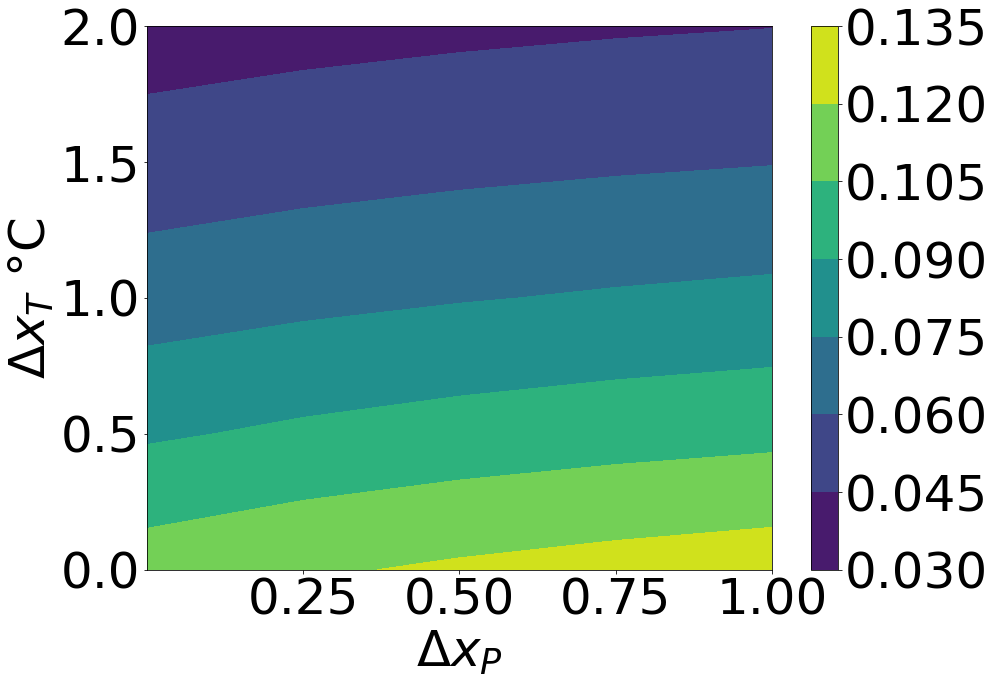

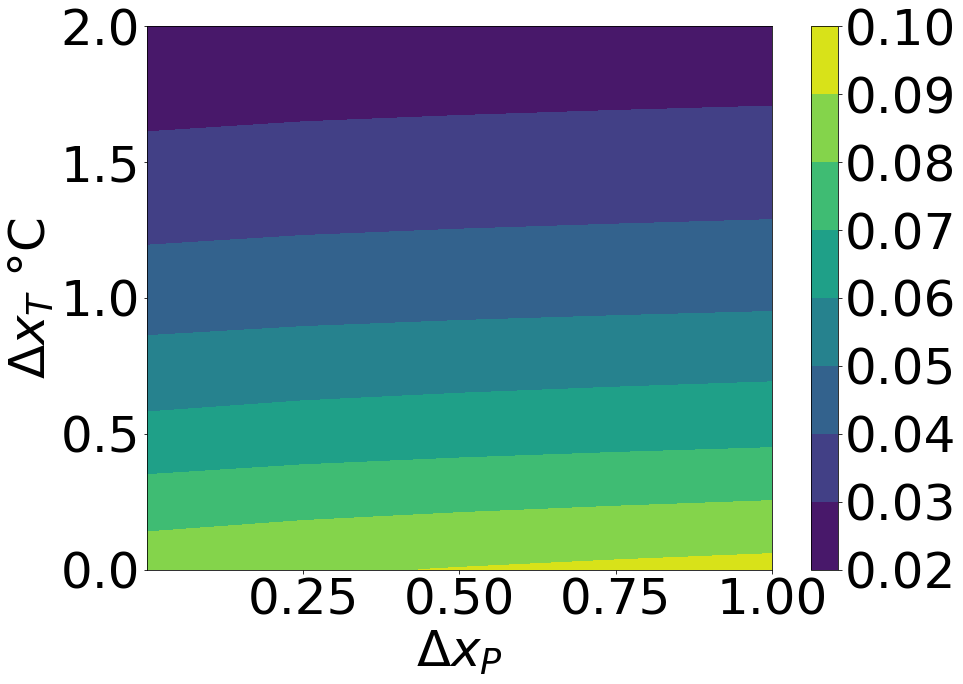

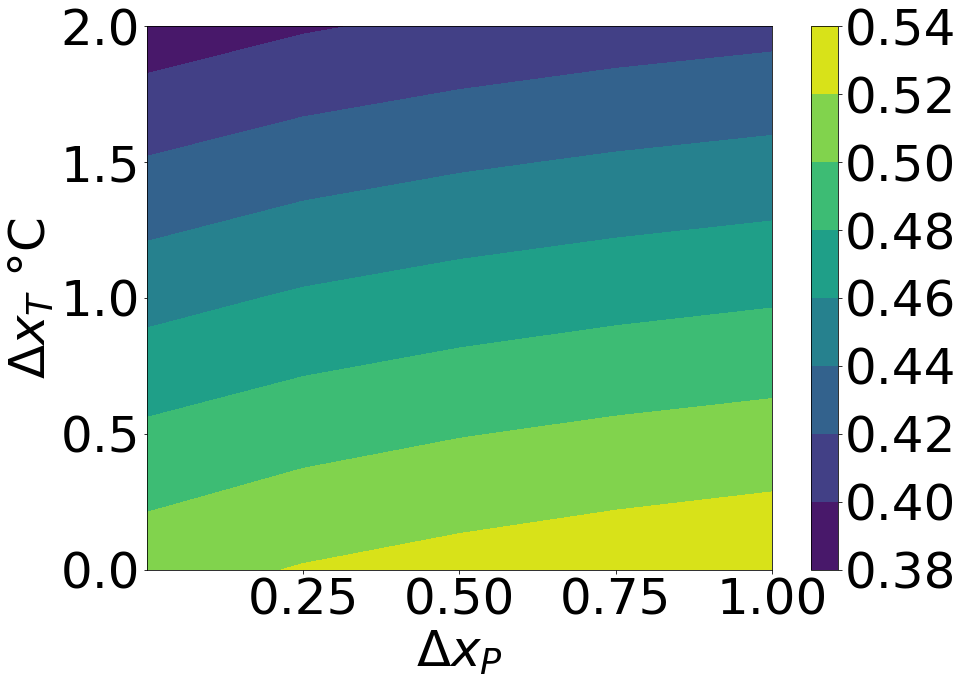

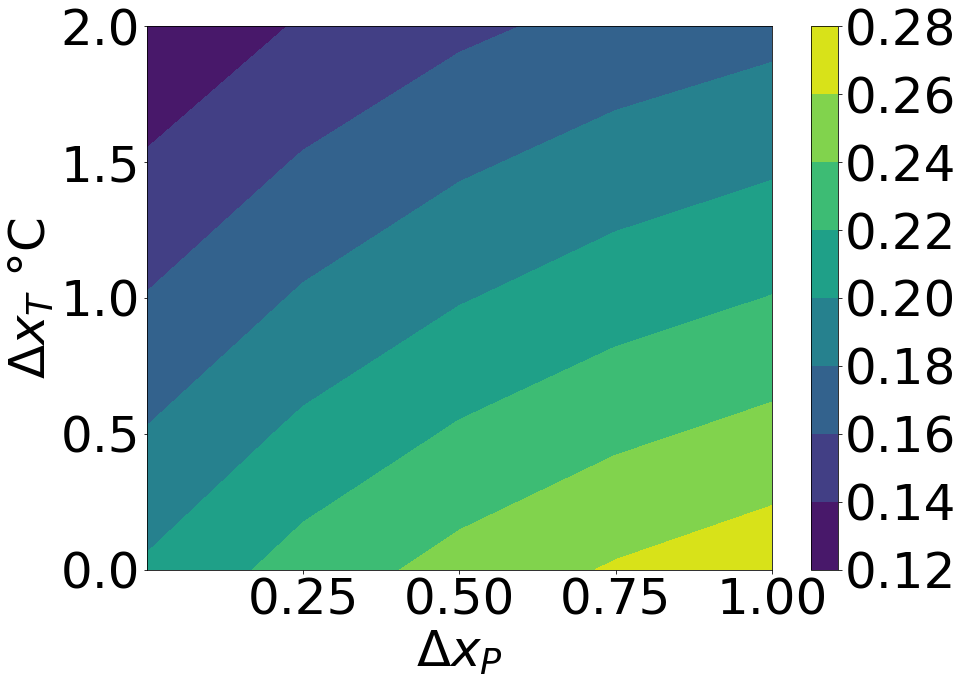

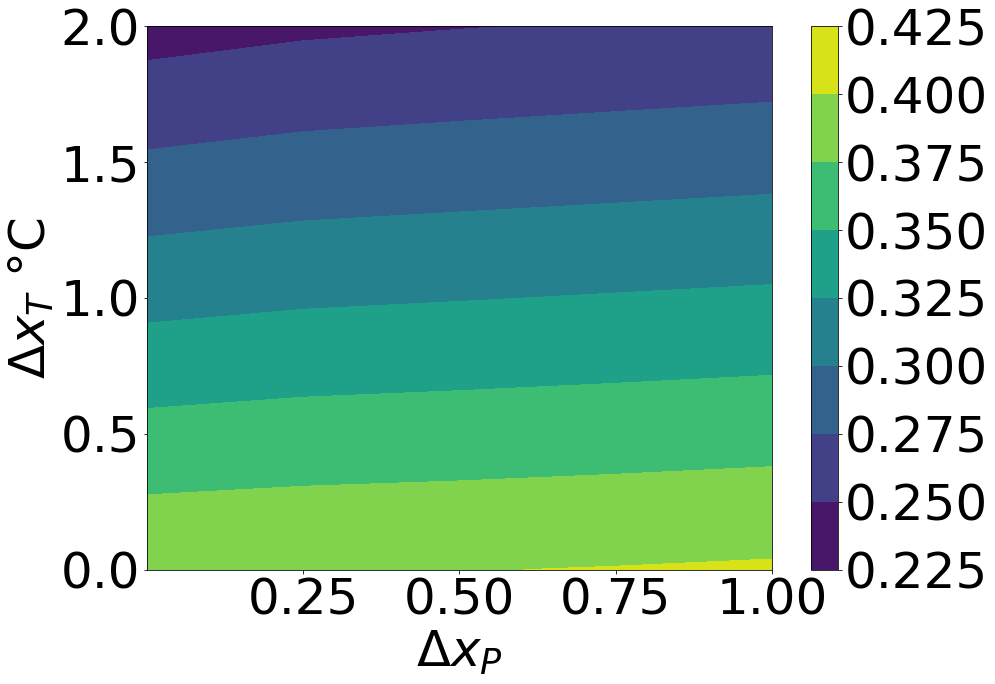

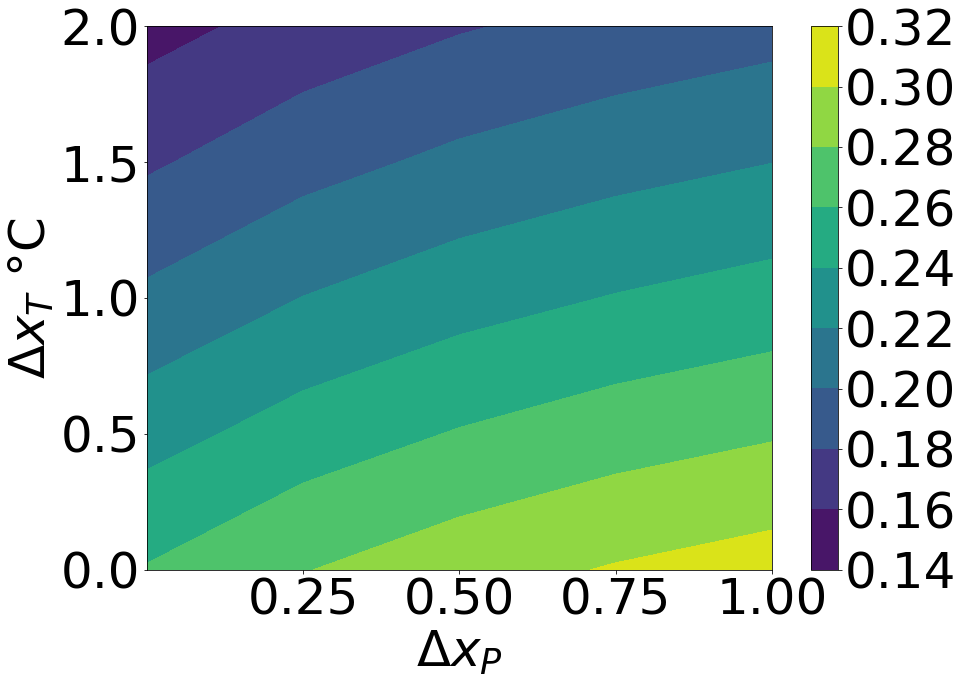

In [19]:
temp_change_arr = np.arange(0,2.5,0.50)
prec_change_arr = np.arange(0,1.25,0.25)

X = prec_change_arr
Y = temp_change_arr

plt.rcParams.update({'font.size': 50})


def plot_cluster_mean(X, Y, Z, cluster_id):
    fig, ax = plt.subplots(figsize=(14,10))
    cp = ax.contourf(X, Y, Z)
    ax.set_xlabel(r'$ \Delta x_P$')
    ax.set_ylabel(r'$ \Delta x_T$ $\degree$C')
    ax.set_xticks([0.25, 0.5, 0.75, 1])
    ax.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
    fig.colorbar(cp)
    # plt.savefig('../fqsnow_paper/w2_aug/'+cluster_id+'_mean_Fs.png', bbox_inches='tight')
    plt.show()


# Plot the mean response surface for each cluster
Z = np.array(fqsnow_df_cl0.mean().values.reshape(5,5))
plot_cluster_mean(X,Y,Z, 'cl_1')

Z = np.array(fqsnow_df_cl1.mean().values.reshape(5,5))
plot_cluster_mean(X,Y,Z, 'cl_2')

Z = np.array(fqsnow_df_cl2.mean().values.reshape(5,5))
plot_cluster_mean(X,Y,Z, 'cl_3')

Z = np.array(fqsnow_df_cl3.mean().values.reshape(5,5))
plot_cluster_mean(X,Y,Z, 'cl_4')

Z = np.array(fqsnow_df_cl4.mean().values.reshape(5,5))
plot_cluster_mean(X,Y,Z, 'cl_5')

Z = np.array(fqsnow_df_cl5.mean().values.reshape(5,5))
plot_cluster_mean(X,Y,Z, 'cl_6')

In [21]:
# fqsnow_df_cl0
# Keep only the rows with matching entries in fqsnow_df
# soil_data_clust = pd.DataFrame()
# for idx in fqsnow_df_cl5.index:
#     lat, lon = getCoordinateFromText(idx, 'fluxes_vic_cropsyst_', '')
#     df_row = soil_data_all.loc[(soil_data_all[2] == lat) & (soil_data_all[3] == lon)]
#     soil_data_clust = pd.concat([soil_data_clust, df_row])

# soil_data_clust = soil_data_clust.reset_index(drop=True)

# soil_data_clust = soil_data_clust.rename(columns={1:'grid', 2: 'lat', 3: 'lon', 4: 'infilt', 5: 'Ds', 6: 'DsMax', 7: 'Ws', 8:'c',
#                                               9:'expt0', 10:'expt1', 11:'expt2', 12:'expt3', 13:'expt4', 14:'expt5', 15:'expt6', 16:'expt7', 17:'expt8', 18:'expt9', 19:'expt10', 20:'expt11', 21:'expt12', 22:'expt13', 23:'expt14', 24:'expt15', 25:'expt16',
#                                               26:'Ksat0', 27:'Ksat1', 28:'Ksat2', 29:'Ksat3', 30:'Ksat4', 31:'Ksat5', 32:'Ksat6', 33:'Ksat7', 34:'Ksat8', 35:'Ksat9', 36:'Ksat10', 37:'Ksat11', 38:'Ksat12', 39:'Ksat13', 40:'Ksat14', 41:'Ksat15', 42:'Ksat16',
#                                               43:'phi_s0', 44:'phi_s1', 45:'phi_s2', 46:'phi_s3', 47:'phi_s4', 48:'phi_s5', 49:'phi_s6', 50:'phi_s7', 51:'phi_s8', 52:'phi_s9', 53:'phi_s10', 54:'phi_s11', 55:'phi_s12', 56:'phi_s13', 57:'phi_s14', 58:'phi_s15', 59:'phi_s16',
#                                               60:'init_moist0', 61:'init_moist1', 62:'init_moist2', 63:'init_moist3', 64:'init_moist4', 65:'init_moist5', 66:'init_moist6', 67:'init_moist7', 68:'init_moist8', 69:'init_moist9', 70:'init_moist10', 71:'init_moist11', 72:'init_moist12', 73:'init_moist13', 74:'init_moist14', 75:'init_moist15', 76:'init_moist16',
#                                               77: 'elev',
#                                               78:'depth0', 79:'depth1', 80:'depth2', 81:'depth3', 82:'depth4', 83:'depth5', 84:'depth6', 85:'depth7', 86:'depth8', 87:'depth9', 88:'depth10', 89:'depth11', 90:'depth12', 91:'depth13', 92:'depth14', 93:'depth15', 94:'depth16',
#                                               95: 'avg_T', 96:'dp',
#                                               97:'bubble0', 98:'bubble1', 99:'bubble2', 100:'bubble3', 101:'bubble4', 102:'bubble5', 103:'bubble6', 104:'bubble7', 105:'bubble8', 106:'bubble9', 107:'bubble10', 108:'bubble11', 109:'bubble12', 110:'bubble13', 111:'bubble14', 112:'bubble15', 113:'bubble16',
#                                               114:'quartz0', 115:'quartz1', 116:'quartz2', 117:'quartz3', 118:'quartz4', 119:'quartz5', 120:'quartz6', 121:'quartz7', 122:'quartz8', 123:'quartz9', 124:'quartz10', 125:'quartz11', 126:'quartz12', 127:'quartz13', 128:'quartz14', 129:'quartz15', 130:'quartz16',
#                                               131:'bulk_density0', 132:'bulk_density1', 133:'bulk_density2', 134:'bulk_density3', 135:'bulk_density4', 136:'bulk_density5', 137:'bulk_density6', 138:'bulk_density7', 139:'bulk_density8', 140:'bulk_density9', 141:'bulk_density10', 142:'bulk_density11', 143:'bulk_density12', 144:'bulk_density13', 145:'bulk_density14', 146:'bulk_density15', 147:'bulk_density16',
#                                               148:'soil_density0', 149:'soil_density1', 150:'soil_density2', 151:'soil_density3', 152:'soil_density4', 153:'soil_density5', 154:'soil_density6', 155:'soil_density7', 156:'soil_density8', 157:'soil_density9', 158:'soil_density10', 159:'soil_density11', 160:'soil_density12', 161:'soil_density13', 162:'soil_density14', 163:'soil_density15', 164:'soil_density16',
#                                               165:'organic0', 166:'organic1', 167:'organic2', 168:'organic3', 169:'organic4', 170:'organic5', 171:'organic6', 172:'organic7', 173:'organic8', 174:'organic9', 175:'organic10', 176:'organic11', 177:'organic12', 178:'organic13', 179:'organic14', 180:'organic15', 181:'organic16',
#                                               182:'bulk_density_org0', 183:'bulk_density_org1', 184:'bulk_density_org2', 185:'bulk_density_org3', 186:'bulk_density_org4', 187:'bulk_density_org5', 188:'bulk_density_org6', 189:'bulk_density_org7', 190:'bulk_density_org8', 191:'bulk_density_org9', 192:'bulk_density_org10', 193:'bulk_density_org11', 194:'bulk_density_org12', 195:'bulk_density_org13', 196:'bulk_density_org14', 197:'bulk_density_org15', 198:'bulk_density_org16',
#                                               199:'soil_density_org0', 200:'soil_density_org1', 201:'soil_density_org2', 202:'soil_density_org3', 203:'soil_density_org4', 204:'soil_density_org5', 205:'soil_density_org6', 206:'soil_density_org7', 207:'soil_density_org8', 208:'soil_density_org9', 209:'soil_density_org10', 210:'soil_density_org11', 211:'soil_density_org12', 212:'soil_density_org13', 213:'soil_density_org14', 214:'soil_density_org15', 215:'soil_density_org16',
#                                               216: 'off_gmt',
#                                               217:'Wcr_FRACT0', 218:'Wcr_FRACT1', 219:'Wcr_FRACT2', 220:'Wcr_FRACT3', 221:'Wcr_FRACT4', 222:'Wcr_FRACT5', 223:'Wcr_FRACT6', 224:'Wcr_FRACT7', 225:'Wcr_FRACT8', 226:'Wcr_FRACT9', 227:'Wcr_FRACT10', 228:'Wcr_FRACT11', 229:'Wcr_FRACT12', 230:'Wcr_FRACT13', 231:'Wcr_FRACT14', 232:'Wcr_FRACT15', 233:'Wcr_FRACT16',
#                                               234:'Wp_FRACT0', 235:'Wp_FRACT1', 236:'Wp_FRACT2', 237:'Wp_FRACT3', 238:'Wp_FRACT4', 239:'Wp_FRACT5', 240:'Wp_FRACT6', 241:'Wp_FRACT7', 242:'Wp_FRACT8', 243:'Wp_FRACT9', 244:'Wp_FRACT10', 245:'Wp_FRACT11', 246:'Wp_FRACT12', 247:'Wp_FRACT13', 248:'Wp_FRACT14', 249:'Wp_FRACT15', 250:'Wp_FRACT16',
#                                               251: 'rough', 252: 'snow_rough', 253: 'annual_prec',
#                                               254:'resid_moist0', 255:'resid_moist1', 256:'resid_moist2', 257:'resid_moist3', 258:'resid_moist4', 259:'resid_moist5', 260:'resid_moist6', 261:'resid_moist7', 262:'resid_moist8', 263:'resid_moist9', 264:'resid_moist10', 265:'resid_moist11', 266:'resid_moist12', 267:'resid_moist13', 268:'resid_moist14', 269:'resid_moist15', 270:'resid_moist16'
#                                              })

# soil_data_clust = soil_data_clust[['grid', 'infilt', 'Ds', 'DsMax', 'Ws', 'c', 'elev', 'avg_T', 'annual_prec']]
# soil_data_clust = soil_data_clust.set_index('grid')

# elev_summary = soil_data_clust['elev'].describe()
# print(elev_summary)

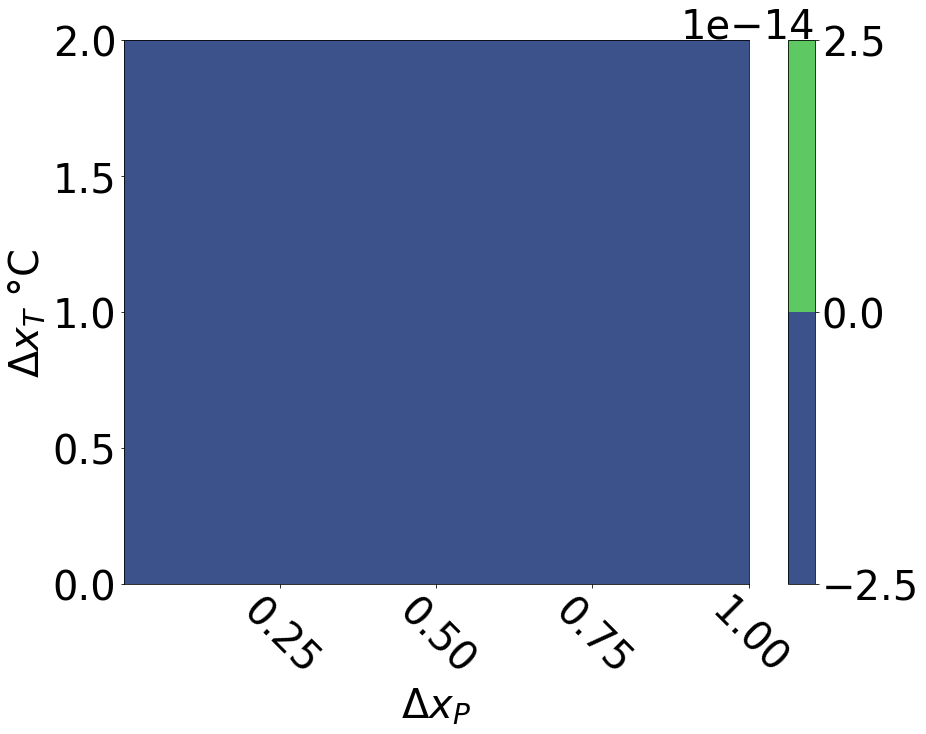

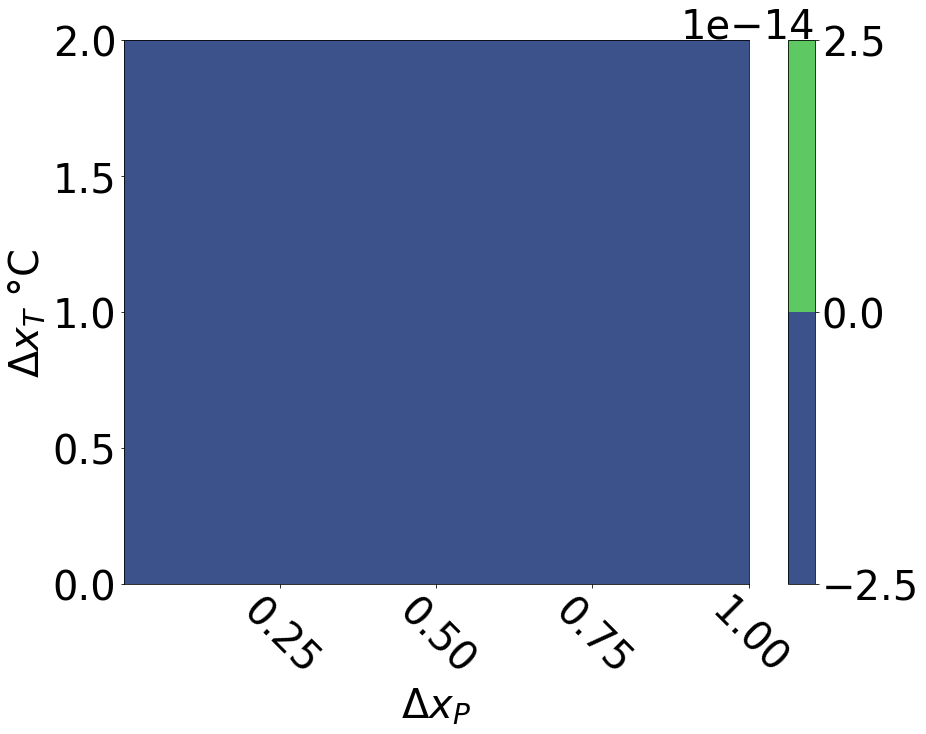

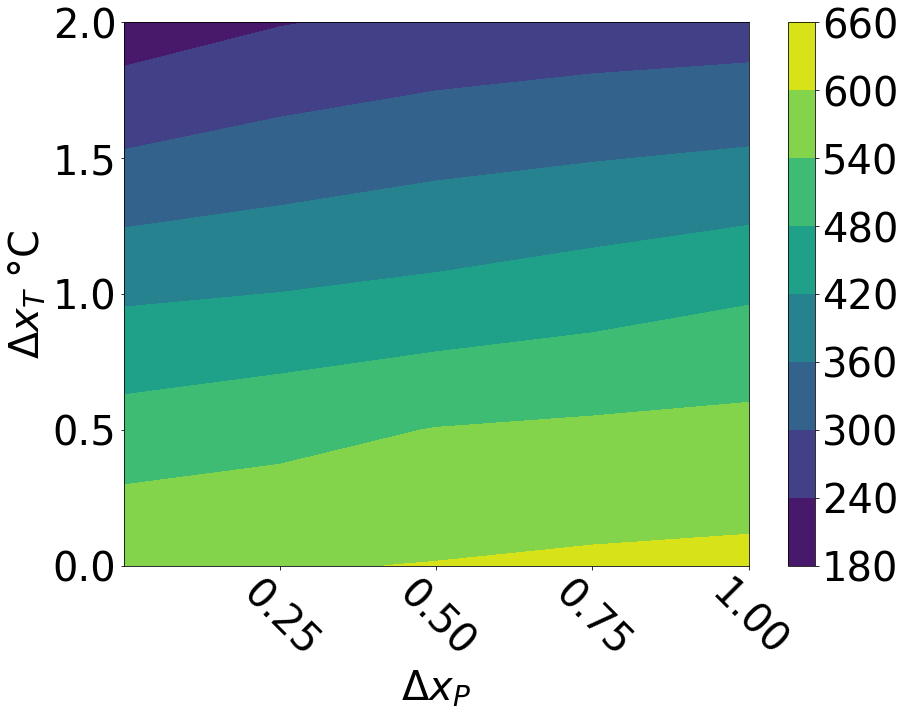

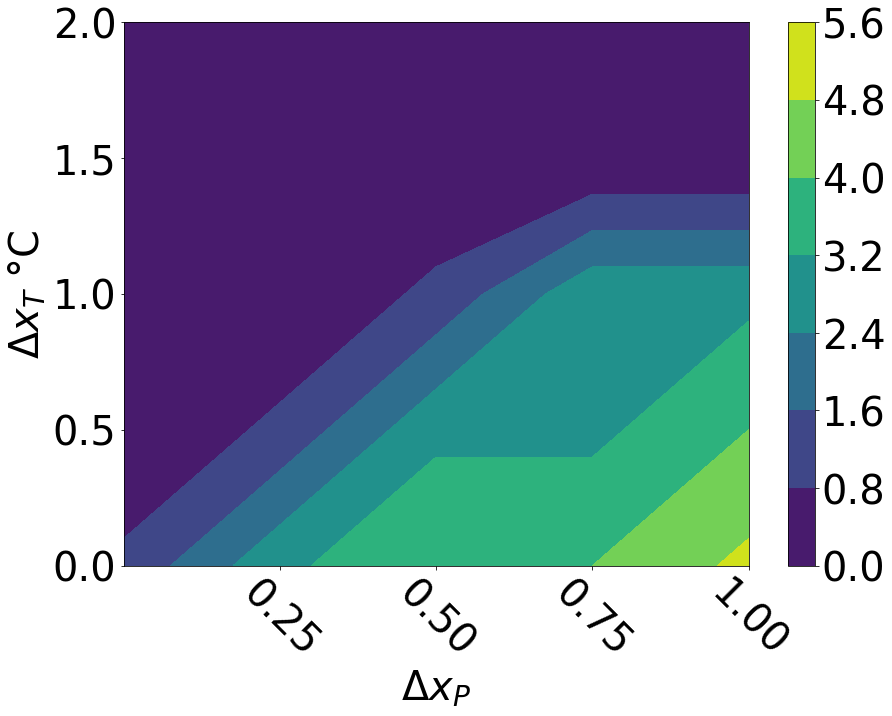

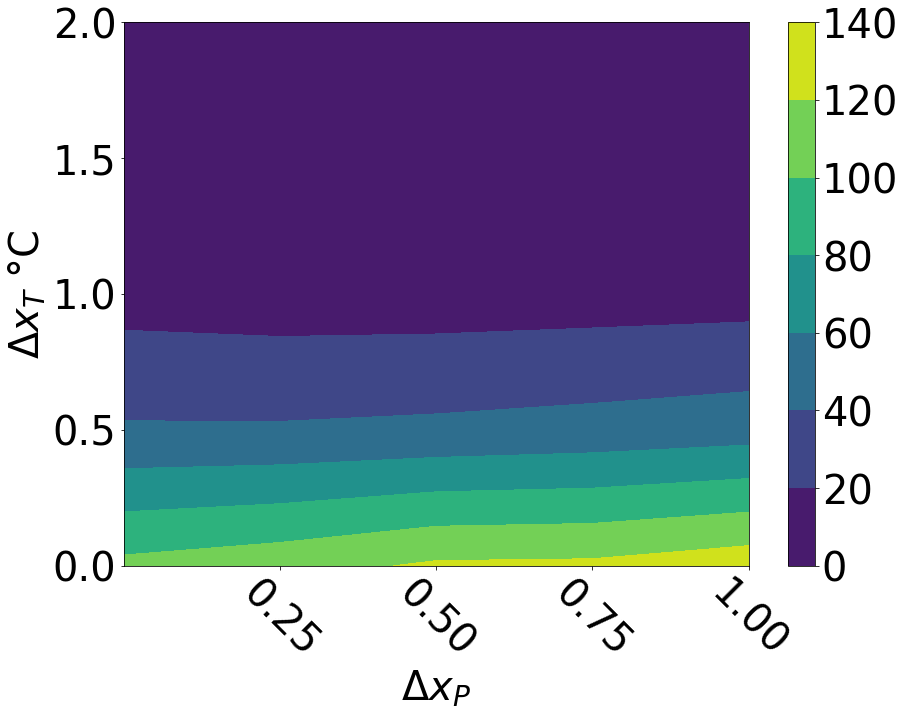

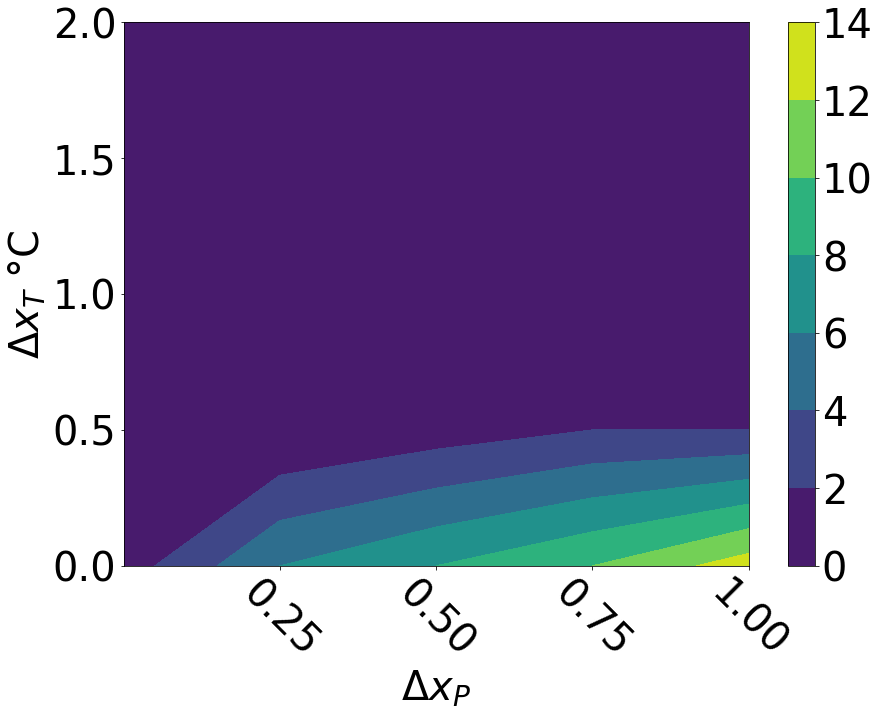

In [76]:
def plot_snow_dom(fqsnow_df_cl, cluster_id, levels = None):
    temp_change_arr = np.arange(0,2.5,0.50)
    prec_change_arr = np.arange(0,1.25,0.25)

    X = prec_change_arr
    Y = temp_change_arr
    run_id = 0
    snow_mat = []

    for temp_chg in temp_change_arr:
        snow_vect = []

        for prec_chg in prec_change_arr:
            runKey = 'run' + str(run_id)
            snow_dom = fqsnow_df_cl[runKey][fqsnow_df_cl[runKey] >= 0.5].count()
            snow_vect.append(snow_dom)
            run_id = run_id + 1

        snow_mat.append(snow_vect)

    Z = np.array(snow_mat)
    # print(Z)
    
    fig, ax = plt.subplots(1,1, figsize=(14,10))
    cp = ax.contourf(X, Y, Z, levels = levels)
    ax.set_xlabel(r'$ \Delta x_P$')
    ax.set_ylabel(r'$ \Delta x_T$ $\degree$C')
    ax.set_xticks([0.25, 0.5, 0.75, 1])
    ax.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
    ax.xaxis.set_tick_params(rotation=-45)
    fig.colorbar(cp)
    # plt.savefig('../fqsnow_paper/w2_aug/'+cluster_id+'_snow_dom.png', bbox_inches='tight')
    plt.show()
    

# Plot the number of snow-dominated cells in each cluster
plt.rcParams.update({'font.size': 40})
#, np.linspace(0,18,10)
plot_snow_dom(fqsnow_df_cl0, 'cl_1')
plot_snow_dom(fqsnow_df_cl1, 'cl_2')
plot_snow_dom(fqsnow_df_cl2, 'cl_3')
plot_snow_dom(fqsnow_df_cl3, 'cl_4')
plot_snow_dom(fqsnow_df_cl4, 'cl_5')
plot_snow_dom(fqsnow_df_cl5, 'cl_6')

## Prepare features

In [26]:
# # Code not required

# count = 9
# finalText = ''
# for a in range(17):
#     text = 'expt' + str(a)
#     elem = f'{count}:\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)


# count = 26
# finalText = ''
# for a in range(17):
#     text = 'Ksat' + str(a)
#     elem = f'{count}:\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 43
# finalText = ''
# for a in range(17):
#     text = 'phi_s' + str(a)
#     elem = f'{count}:\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 60
# finalText = ''
# for a in range(17):
#     text = 'init_moist' + str(a)
#     elem = f'{count}:\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 78
# finalText = ''
# for a in range(17):
#     text = 'depth' + str(a)
#     elem = f'{count}:\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 97
# finalText = ''
# for a in range(17):
#     text = 'bubble' + str(a)
#     elem = f'{count}:\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)
    
# count = 114
# finalText = ''
# for a in range(17):
#     text = 'quartz' + str(a)
#     elem = f'{count}:\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 131
# finalText = ''
# for a in range(17):
#     text = 'bulk_density' + str(a)
#     elem = f'{count}:\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 148 # to 164
# finalText = ''
# for a in range(17):
#     text = 'soil_density' + str(a)
#     elem = f'{count}:\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# print('\n')

# count = 165 # 181
# finalText = ''
# for a in range(17):
#     text = 'organic' + str(a)
#     elem = f'{count}:\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 182 # 198
# finalText = ''
# for a in range(17):
#     text = 'bulk_density_org' + str(a)
#     elem = f'{count}:\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 199 # 215
# finalText = ''
# for a in range(17):
#     text = 'soil_density_org' + str(a)
#     elem = f'{count}:\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# # 216: off_gmt

# count = 217 # 233
# finalText = ''
# for a in range(17):
#     text = 'Wcr_FRACT' + str(a)
#     elem = f'{count}:\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 234 # 250
# finalText = ''
# for a in range(17):
#     text = 'Wp_FRACT' + str(a)
#     elem = f'{count}:\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# # 251: rough
# # 252: snow_rough
# # 253: annual_prec

# count = 254 # 270
# finalText = ''
# for a in range(17):
#     text = 'resid_moist' + str(a)
#     elem = f'{count}:\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# # 271: fs_active
# # 272: frost_slope
# # 273: max_snow_distrib_slope
# # 274: July_Tavg

In [28]:
# # Code not required

# count = 9
# finalText = ''
# for a in range(17):
#     text = 'expt' + str(a)
#     elem = f'\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)


# count = 26
# finalText = ''
# for a in range(17):
#     text = 'Ksat' + str(a)
#     elem = f'\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 43
# finalText = ''
# for a in range(17):
#     text = 'phi_s' + str(a)
#     elem = f'\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 60
# finalText = ''
# for a in range(17):
#     text = 'init_moist' + str(a)
#     elem = f'\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 78
# finalText = ''
# for a in range(17):
#     text = 'depth' + str(a)
#     elem = f'\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 97
# finalText = ''
# for a in range(17):
#     text = 'bubble' + str(a)
#     elem = f'\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)
    
# count = 114
# finalText = ''
# for a in range(17):
#     text = 'quartz' + str(a)
#     elem = f'\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 131
# finalText = ''
# for a in range(17):
#     text = 'bulk_density' + str(a)
#     elem = f'\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 148
# finalText = ''
# for a in range(17):
#     text = 'soil_density' + str(a)
#     elem = f'\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# print('\n')


# count = 165 # 181
# finalText = ''
# for a in range(17):
#     text = 'organic' + str(a)
#     elem = f'\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 182 # 198
# finalText = ''
# for a in range(17):
#     text = 'bulk_density_org' + str(a)
#     elem = f'\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 199 # 215
# finalText = ''
# for a in range(17):
#     text = 'soil_density_org' + str(a)
#     elem = f'\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# # 216: off_gmt

# count = 217 # 233
# finalText = ''
# for a in range(17):
#     text = 'Wcr_FRACT' + str(a)
#     elem = f'\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# count = 234 # 250
# finalText = ''
# for a in range(17):
#     text = 'Wp_FRACT' + str(a)
#     elem = f'\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# # 251: rough
# # 252: snow_rough
# # 253: annual_prec

# count = 254 # 270
# finalText = ''
# for a in range(17):
#     text = 'resid_moist' + str(a)
#     elem = f'\'{text}\''
#     finalText = finalText + elem + ', '
#     count = count+1

# print(finalText)

# # 271: fs_active
# # 272: frost_slope
# # 273: max_snow_distrib_slope
# # 274: July_Tavg

In [30]:
# Nlayer = 17
# print(11*Nlayer+13)
# print(12*Nlayer+12)

# 290 columns read (includes grid enabled, grid id, lat, lon)

# 266 required parameters selected
# EDA
# 36 parameters constant across grid cells were dropped
# 230 remaining
# avgT and annual_rec were dropped
# 228 remaining
# XCORR
# 202 were dropped due to high correlation (>0.9)
# 26 reamining
# plt.rcParams.update({'font.size': 22})

In [77]:
# Read elev data from soil file
soil_file = '../for_run_VIC_CropSyst/VIC-CropSyst/Simulation/Database/Soil/all_calibrated_plus_uncalibrated_soil_210106.txt'

soil_data_all = pd.read_csv(soil_file, header=None, delim_whitespace=True)

In [78]:
# Keep only the rows with matching entries in fqsnow_df
soil_data_sel = pd.DataFrame()
for idx in fqsnow_df.index:
    lat, lon = getCoordinateFromText(idx, 'fluxes_vic_cropsyst_', '')
    df_row = soil_data_all.loc[(soil_data_all[2] == lat) & (soil_data_all[3] == lon)]
    soil_data_sel = pd.concat([soil_data_sel, df_row])

soil_data_sel = soil_data_sel.reset_index(drop=True)

In [79]:
soil_data_sel = soil_data_sel.rename(columns={1:'grid', 2: 'lat', 3: 'lon', 4: 'infilt', 5: 'Ds', 6: 'DsMax', 7: 'Ws', 8:'c',
                                              9:'expt0', 10:'expt1', 11:'expt2', 12:'expt3', 13:'expt4', 14:'expt5', 15:'expt6', 16:'expt7', 17:'expt8', 18:'expt9', 19:'expt10', 20:'expt11', 21:'expt12', 22:'expt13', 23:'expt14', 24:'expt15', 25:'expt16',
                                              26:'Ksat0', 27:'Ksat1', 28:'Ksat2', 29:'Ksat3', 30:'Ksat4', 31:'Ksat5', 32:'Ksat6', 33:'Ksat7', 34:'Ksat8', 35:'Ksat9', 36:'Ksat10', 37:'Ksat11', 38:'Ksat12', 39:'Ksat13', 40:'Ksat14', 41:'Ksat15', 42:'Ksat16',
                                              43:'phi_s0', 44:'phi_s1', 45:'phi_s2', 46:'phi_s3', 47:'phi_s4', 48:'phi_s5', 49:'phi_s6', 50:'phi_s7', 51:'phi_s8', 52:'phi_s9', 53:'phi_s10', 54:'phi_s11', 55:'phi_s12', 56:'phi_s13', 57:'phi_s14', 58:'phi_s15', 59:'phi_s16',
                                              60:'init_moist0', 61:'init_moist1', 62:'init_moist2', 63:'init_moist3', 64:'init_moist4', 65:'init_moist5', 66:'init_moist6', 67:'init_moist7', 68:'init_moist8', 69:'init_moist9', 70:'init_moist10', 71:'init_moist11', 72:'init_moist12', 73:'init_moist13', 74:'init_moist14', 75:'init_moist15', 76:'init_moist16',
                                              77: 'elev',
                                              78:'depth0', 79:'depth1', 80:'depth2', 81:'depth3', 82:'depth4', 83:'depth5', 84:'depth6', 85:'depth7', 86:'depth8', 87:'depth9', 88:'depth10', 89:'depth11', 90:'depth12', 91:'depth13', 92:'depth14', 93:'depth15', 94:'depth16',
                                              95: 'avg_T', 96:'dp',
                                              97:'bubble0', 98:'bubble1', 99:'bubble2', 100:'bubble3', 101:'bubble4', 102:'bubble5', 103:'bubble6', 104:'bubble7', 105:'bubble8', 106:'bubble9', 107:'bubble10', 108:'bubble11', 109:'bubble12', 110:'bubble13', 111:'bubble14', 112:'bubble15', 113:'bubble16',
                                              114:'quartz0', 115:'quartz1', 116:'quartz2', 117:'quartz3', 118:'quartz4', 119:'quartz5', 120:'quartz6', 121:'quartz7', 122:'quartz8', 123:'quartz9', 124:'quartz10', 125:'quartz11', 126:'quartz12', 127:'quartz13', 128:'quartz14', 129:'quartz15', 130:'quartz16',
                                              131:'bulk_density0', 132:'bulk_density1', 133:'bulk_density2', 134:'bulk_density3', 135:'bulk_density4', 136:'bulk_density5', 137:'bulk_density6', 138:'bulk_density7', 139:'bulk_density8', 140:'bulk_density9', 141:'bulk_density10', 142:'bulk_density11', 143:'bulk_density12', 144:'bulk_density13', 145:'bulk_density14', 146:'bulk_density15', 147:'bulk_density16',
                                              148:'soil_density0', 149:'soil_density1', 150:'soil_density2', 151:'soil_density3', 152:'soil_density4', 153:'soil_density5', 154:'soil_density6', 155:'soil_density7', 156:'soil_density8', 157:'soil_density9', 158:'soil_density10', 159:'soil_density11', 160:'soil_density12', 161:'soil_density13', 162:'soil_density14', 163:'soil_density15', 164:'soil_density16',
                                              165:'organic0', 166:'organic1', 167:'organic2', 168:'organic3', 169:'organic4', 170:'organic5', 171:'organic6', 172:'organic7', 173:'organic8', 174:'organic9', 175:'organic10', 176:'organic11', 177:'organic12', 178:'organic13', 179:'organic14', 180:'organic15', 181:'organic16',
                                              182:'bulk_density_org0', 183:'bulk_density_org1', 184:'bulk_density_org2', 185:'bulk_density_org3', 186:'bulk_density_org4', 187:'bulk_density_org5', 188:'bulk_density_org6', 189:'bulk_density_org7', 190:'bulk_density_org8', 191:'bulk_density_org9', 192:'bulk_density_org10', 193:'bulk_density_org11', 194:'bulk_density_org12', 195:'bulk_density_org13', 196:'bulk_density_org14', 197:'bulk_density_org15', 198:'bulk_density_org16',
                                              199:'soil_density_org0', 200:'soil_density_org1', 201:'soil_density_org2', 202:'soil_density_org3', 203:'soil_density_org4', 204:'soil_density_org5', 205:'soil_density_org6', 206:'soil_density_org7', 207:'soil_density_org8', 208:'soil_density_org9', 209:'soil_density_org10', 210:'soil_density_org11', 211:'soil_density_org12', 212:'soil_density_org13', 213:'soil_density_org14', 214:'soil_density_org15', 215:'soil_density_org16',
                                              216: 'off_gmt',
                                              217:'Wcr_FRACT0', 218:'Wcr_FRACT1', 219:'Wcr_FRACT2', 220:'Wcr_FRACT3', 221:'Wcr_FRACT4', 222:'Wcr_FRACT5', 223:'Wcr_FRACT6', 224:'Wcr_FRACT7', 225:'Wcr_FRACT8', 226:'Wcr_FRACT9', 227:'Wcr_FRACT10', 228:'Wcr_FRACT11', 229:'Wcr_FRACT12', 230:'Wcr_FRACT13', 231:'Wcr_FRACT14', 232:'Wcr_FRACT15', 233:'Wcr_FRACT16',
                                              234:'Wp_FRACT0', 235:'Wp_FRACT1', 236:'Wp_FRACT2', 237:'Wp_FRACT3', 238:'Wp_FRACT4', 239:'Wp_FRACT5', 240:'Wp_FRACT6', 241:'Wp_FRACT7', 242:'Wp_FRACT8', 243:'Wp_FRACT9', 244:'Wp_FRACT10', 245:'Wp_FRACT11', 246:'Wp_FRACT12', 247:'Wp_FRACT13', 248:'Wp_FRACT14', 249:'Wp_FRACT15', 250:'Wp_FRACT16',
                                              251: 'rough', 252: 'snow_rough', 253: 'annual_prec',
                                              254:'resid_moist0', 255:'resid_moist1', 256:'resid_moist2', 257:'resid_moist3', 258:'resid_moist4', 259:'resid_moist5', 260:'resid_moist6', 261:'resid_moist7', 262:'resid_moist8', 263:'resid_moist9', 264:'resid_moist10', 265:'resid_moist11', 266:'resid_moist12', 267:'resid_moist13', 268:'resid_moist14', 269:'resid_moist15', 270:'resid_moist16'
                                             })


# soil_data_sel = soil_data_sel[['grid', 'lat', 'lon', 'infilt', 'Ds', 'DsMax', 'Ws', 'elev']]
# soil_data_sel = soil_data_sel[['infilt', 'Ds', 'DsMax', 'Ws', 'elev']]

soil_data_sel = soil_data_sel[['grid', 'lat', 'lon', 'infilt', 'Ds', 'DsMax', 'Ws', 'c', 'elev', 'avg_T', 'dp', 'off_gmt', 'expt0', 'expt1', 'expt2', 'expt3', 'expt4', 'expt5', 'expt6', 'expt7', 'expt8', 'expt9', 'expt10', 'expt11', 'expt12', 'expt13', 'expt14', 'expt15', 'expt16',
'Ksat0', 'Ksat1', 'Ksat2', 'Ksat3', 'Ksat4', 'Ksat5', 'Ksat6', 'Ksat7', 'Ksat8', 'Ksat9', 'Ksat10', 'Ksat11', 'Ksat12', 'Ksat13', 'Ksat14', 'Ksat15', 'Ksat16', 
'phi_s0', 'phi_s1', 'phi_s2', 'phi_s3', 'phi_s4', 'phi_s5', 'phi_s6', 'phi_s7', 'phi_s8', 'phi_s9', 'phi_s10', 'phi_s11', 'phi_s12', 'phi_s13', 'phi_s14', 'phi_s15', 'phi_s16', 
'init_moist0', 'init_moist1', 'init_moist2', 'init_moist3', 'init_moist4', 'init_moist5', 'init_moist6', 'init_moist7', 'init_moist8', 'init_moist9', 'init_moist10', 'init_moist11', 'init_moist12', 'init_moist13', 'init_moist14', 'init_moist15', 'init_moist16',
'depth0', 'depth1', 'depth2', 'depth3', 'depth4', 'depth5', 'depth6', 'depth7', 'depth8', 'depth9', 'depth10', 'depth11', 'depth12', 'depth13', 'depth14', 'depth15', 'depth16',
'bubble0', 'bubble1', 'bubble2', 'bubble3', 'bubble4', 'bubble5', 'bubble6', 'bubble7', 'bubble8', 'bubble9', 'bubble10', 'bubble11', 'bubble12', 'bubble13', 'bubble14', 'bubble15', 'bubble16',
'quartz0', 'quartz1', 'quartz2', 'quartz3', 'quartz4', 'quartz5', 'quartz6', 'quartz7', 'quartz8', 'quartz9', 'quartz10', 'quartz11', 'quartz12', 'quartz13', 'quartz14', 'quartz15', 'quartz16', 
'bulk_density0', 'bulk_density1', 'bulk_density2', 'bulk_density3', 'bulk_density4', 'bulk_density5', 'bulk_density6', 'bulk_density7', 'bulk_density8', 'bulk_density9', 'bulk_density10', 'bulk_density11', 'bulk_density12', 'bulk_density13', 'bulk_density14', 'bulk_density15', 'bulk_density16', 
'soil_density0', 'soil_density1', 'soil_density2', 'soil_density3', 'soil_density4', 'soil_density5', 'soil_density6', 'soil_density7', 'soil_density8', 'soil_density9', 'soil_density10', 'soil_density11', 'soil_density12', 'soil_density13', 'soil_density14', 'soil_density15', 'soil_density16', 
'organic0', 'organic1', 'organic2', 'organic3', 'organic4', 'organic5', 'organic6', 'organic7', 'organic8', 'organic9', 'organic10', 'organic11', 'organic12', 'organic13', 'organic14', 'organic15', 'organic16', 
'bulk_density_org0', 'bulk_density_org1', 'bulk_density_org2', 'bulk_density_org3', 'bulk_density_org4', 'bulk_density_org5', 'bulk_density_org6', 'bulk_density_org7', 'bulk_density_org8', 'bulk_density_org9', 'bulk_density_org10', 'bulk_density_org11', 'bulk_density_org12', 'bulk_density_org13', 'bulk_density_org14', 'bulk_density_org15', 'bulk_density_org16', 
'soil_density_org0', 'soil_density_org1', 'soil_density_org2', 'soil_density_org3', 'soil_density_org4', 'soil_density_org5', 'soil_density_org6', 'soil_density_org7', 'soil_density_org8', 'soil_density_org9', 'soil_density_org10', 'soil_density_org11', 'soil_density_org12', 'soil_density_org13', 'soil_density_org14', 'soil_density_org15', 'soil_density_org16', 
'Wcr_FRACT0', 'Wcr_FRACT1', 'Wcr_FRACT2', 'Wcr_FRACT3', 'Wcr_FRACT4', 'Wcr_FRACT5', 'Wcr_FRACT6', 'Wcr_FRACT7', 'Wcr_FRACT8', 'Wcr_FRACT9', 'Wcr_FRACT10', 'Wcr_FRACT11', 'Wcr_FRACT12', 'Wcr_FRACT13', 'Wcr_FRACT14', 'Wcr_FRACT15', 'Wcr_FRACT16', 
'Wp_FRACT0', 'Wp_FRACT1', 'Wp_FRACT2', 'Wp_FRACT3', 'Wp_FRACT4', 'Wp_FRACT5', 'Wp_FRACT6', 'Wp_FRACT7', 'Wp_FRACT8', 'Wp_FRACT9', 'Wp_FRACT10', 'Wp_FRACT11', 'Wp_FRACT12', 'Wp_FRACT13', 'Wp_FRACT14', 'Wp_FRACT15', 'Wp_FRACT16', 
'rough', 'snow_rough', 'annual_prec',
'resid_moist0', 'resid_moist1', 'resid_moist2', 'resid_moist3', 'resid_moist4', 'resid_moist5', 'resid_moist6', 'resid_moist7', 'resid_moist8', 'resid_moist9', 'resid_moist10', 'resid_moist11', 'resid_moist12', 'resid_moist13', 'resid_moist14', 'resid_moist15', 'resid_moist16']]
soil_data_sel = soil_data_sel.set_index('grid')
soil_data_sel = soil_data_sel.drop(['lat', 'lon'], axis=1)

In [80]:
soil_data_sel.describe()

infilt           Ds        DsMax           Ws       c  \
count  4834.000000  4834.000000  4834.000000  4834.000000  4834.0   
mean      0.232173     0.361974    10.993550     0.546264     2.0   
std       0.078255     0.259190     6.538623     0.250149     0.0   
min       0.014946     0.032024     0.169521     0.066507     2.0   
25%       0.194178     0.100000     7.300970     0.370905     2.0   
50%       0.260755     0.341642    10.000000     0.536874     2.0   
75%       0.297822     0.583856    17.145200     0.750000     2.0   
max       0.300000     0.995996    29.989600     0.994086     2.0   

              elev        avg_T      dp  off_gmt        expt0  ...  \
count  4834.000000  4834.000000  4834.0   4834.0  4834.000000  ...   
mean    644.029802     7.931541     4.0     -8.0    11.464688  ...   
std     431.957924     2.638172     0.0      0.0     2.734812  ...   
min       1.000000    -1.102500     4.0     -8.0     3.374773  ...   
25%     302.500511     6.489600     4.0     -8.0    10.197200  ...   
50%     599.530487     8.505600     4.0     -8.0    10.898000  ...   
75%     864.234497     9.950900     4.0     -8.0    12.842600  ...   
max    3408.639890    12.178500     4.0     -8.0    22.745500  ...   

       resid_moist7  resid_moist8  resid_moist9  resid_moist10  resid_moist11  \
count        4834.0        4834.0        4834.0         4834.0         4834.0   
mean            0.0           0.0           0.0            0.0            0.0   
std             0.0           0.0           0.0            0.0            0.0   
min             0.0           0.0           0.0            0.0            0.0   
25%             0.0           0.0           0.0            0.0            0.0   
50%             0.0           0.0           0.0            0.0            0.0   
75%             0.0           0.0           0.0            0.0            0.0   
max             0.0           0.0           0.0            0.0            0.0   

       resid_moist12  resid_moist13  resid_moist14  resid_moist15  \
count         4834.0         4834.0         4834.0         4834.0   
mean             0.0            0.0            0.0            0.0   
std              0.0            0.0            0.0            0.0   
min              0.0            0.0            0.0            0.0   
25%              0.0            0.0            0.0            0.0   
50%              0.0            0.0            0.0            0.0   
75%              0.0            0.0            0.0            0.0   
max              0.0            0.0            0.0            0.0   

       resid_moist16  
count         4834.0  
mean             0.0  
std              0.0  
min              0.0  
25%              0.0  
50%              0.0  
75%              0.0  
max              0.0  

[8 rows x 267 columns]

### Exploratory Data Analysis

In [81]:
# Look for missing data

null_check = soil_data_sel.isnull().sum()

null_check[null_check > 0]
# soil_data_sel.columns

Series([], dtype: int64)

In [82]:
# Look for constant columns
dist_check = soil_data_sel.describe()

# Drop columns with standard deviation < 1e-8
to_drop = soil_data_sel.columns[dist_check.loc['std'] < 1e-8]

soil_data_sel = soil_data_sel.drop(to_drop, axis=1)

soil_data_sel.describe()

infilt           Ds        DsMax           Ws         elev  \
count  4834.000000  4834.000000  4834.000000  4834.000000  4834.000000   
mean      0.232173     0.361974    10.993550     0.546264   644.029802   
std       0.078255     0.259190     6.538623     0.250149   431.957924   
min       0.014946     0.032024     0.169521     0.066507     1.000000   
25%       0.194178     0.100000     7.300970     0.370905   302.500511   
50%       0.260755     0.341642    10.000000     0.536874   599.530487   
75%       0.297822     0.583856    17.145200     0.750000   864.234497   
max       0.300000     0.995996    29.989600     0.994086  3408.639890   

             avg_T        expt0        expt1        expt2        expt3  ...  \
count  4834.000000  4834.000000  4834.000000  4834.000000  4834.000000  ...   
mean      7.931541    11.464688    11.517431    11.674010    11.786349  ...   
std       2.638172     2.734812     2.777791     2.844255     2.761642  ...   
min      -1.102500     3.374773     3.374773     3.374773     3.374773  ...   
25%       6.489600    10.197200    10.197200    10.197200    10.346900  ...   
50%       8.505600    10.898000    10.976100    11.073550    11.411000  ...   
75%       9.950900    12.842600    12.842600    13.344300    13.514300  ...   
max      12.178500    22.745500    22.745500    22.745500    22.745500  ...   

         Wp_FRACT8    Wp_FRACT9   Wp_FRACT10   Wp_FRACT11   Wp_FRACT12  \
count  4834.000000  4834.000000  4834.000000  4834.000000  4834.000000   
mean      0.279452     0.284276     0.287473     0.287411     0.285536   
std       0.408111     0.409898     0.410883     0.410942     0.410762   
min       0.116100     0.113400     0.113400     0.113400     0.113400   
25%       0.215800     0.217000     0.217000     0.217000     0.217000   
50%       0.231100     0.238983     0.246400     0.246400     0.234500   
75%       0.305500     0.307300     0.311300     0.307300     0.309700   
max      27.768000    27.768000    27.768000    27.768000    27.768000   

        Wp_FRACT13   Wp_FRACT14   Wp_FRACT15   Wp_FRACT16  annual_prec  
count  4834.000000  4834.000000  4834.000000  4834.000000  4834.000000  
mean      0.286823     0.286807     0.287580     0.289034  1102.726075  
std       0.411295     0.411348     0.411247     0.411309   944.408929  
min       0.113400     0.113400     0.113400     0.113400   161.221000  
25%       0.215800     0.215800     0.215800     0.215806   334.935500  
50%       0.234500     0.234500     0.234500     0.234500   721.599000  
75%       0.323000     0.323000     0.324100     0.330400  1707.750000  
max      27.768000    27.768000    27.768000    27.768000  5522.990000  

[8 rows x 227 columns]

In [83]:
# Constant columns dropped
to_drop

Index(['c', 'dp', 'off_gmt', 'depth0', 'soil_density_org0',
       'soil_density_org1', 'soil_density_org2', 'soil_density_org3',
       'soil_density_org4', 'soil_density_org5', 'soil_density_org6',
       'soil_density_org7', 'soil_density_org8', 'soil_density_org9',
       'soil_density_org10', 'soil_density_org11', 'soil_density_org12',
       'soil_density_org13', 'soil_density_org14', 'soil_density_org15',
       'soil_density_org16', 'rough', 'snow_rough', 'resid_moist0',
       'resid_moist1', 'resid_moist2', 'resid_moist3', 'resid_moist4',
       'resid_moist5', 'resid_moist6', 'resid_moist7', 'resid_moist8',
       'resid_moist9', 'resid_moist10', 'resid_moist11', 'resid_moist12',
       'resid_moist13', 'resid_moist14', 'resid_moist15', 'resid_moist16'],
      dtype='object')

In [84]:
# Drop temp and prec variables
to_drop = ['avg_T', 'annual_prec']
soil_data_sel = soil_data_sel.drop(to_drop, axis=1)

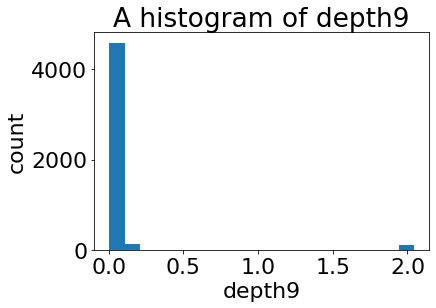

In [85]:
# Univariate Explorations
plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots()

var_name = soil_data_sel.columns[81]

ax.hist(soil_data_sel[var_name], bins=20)

ax.set(title = f'A histogram of {var_name}', xlabel=var_name, ylabel='count')

plt.show();

### Drop correlated features
Note: The process has some manual interventions

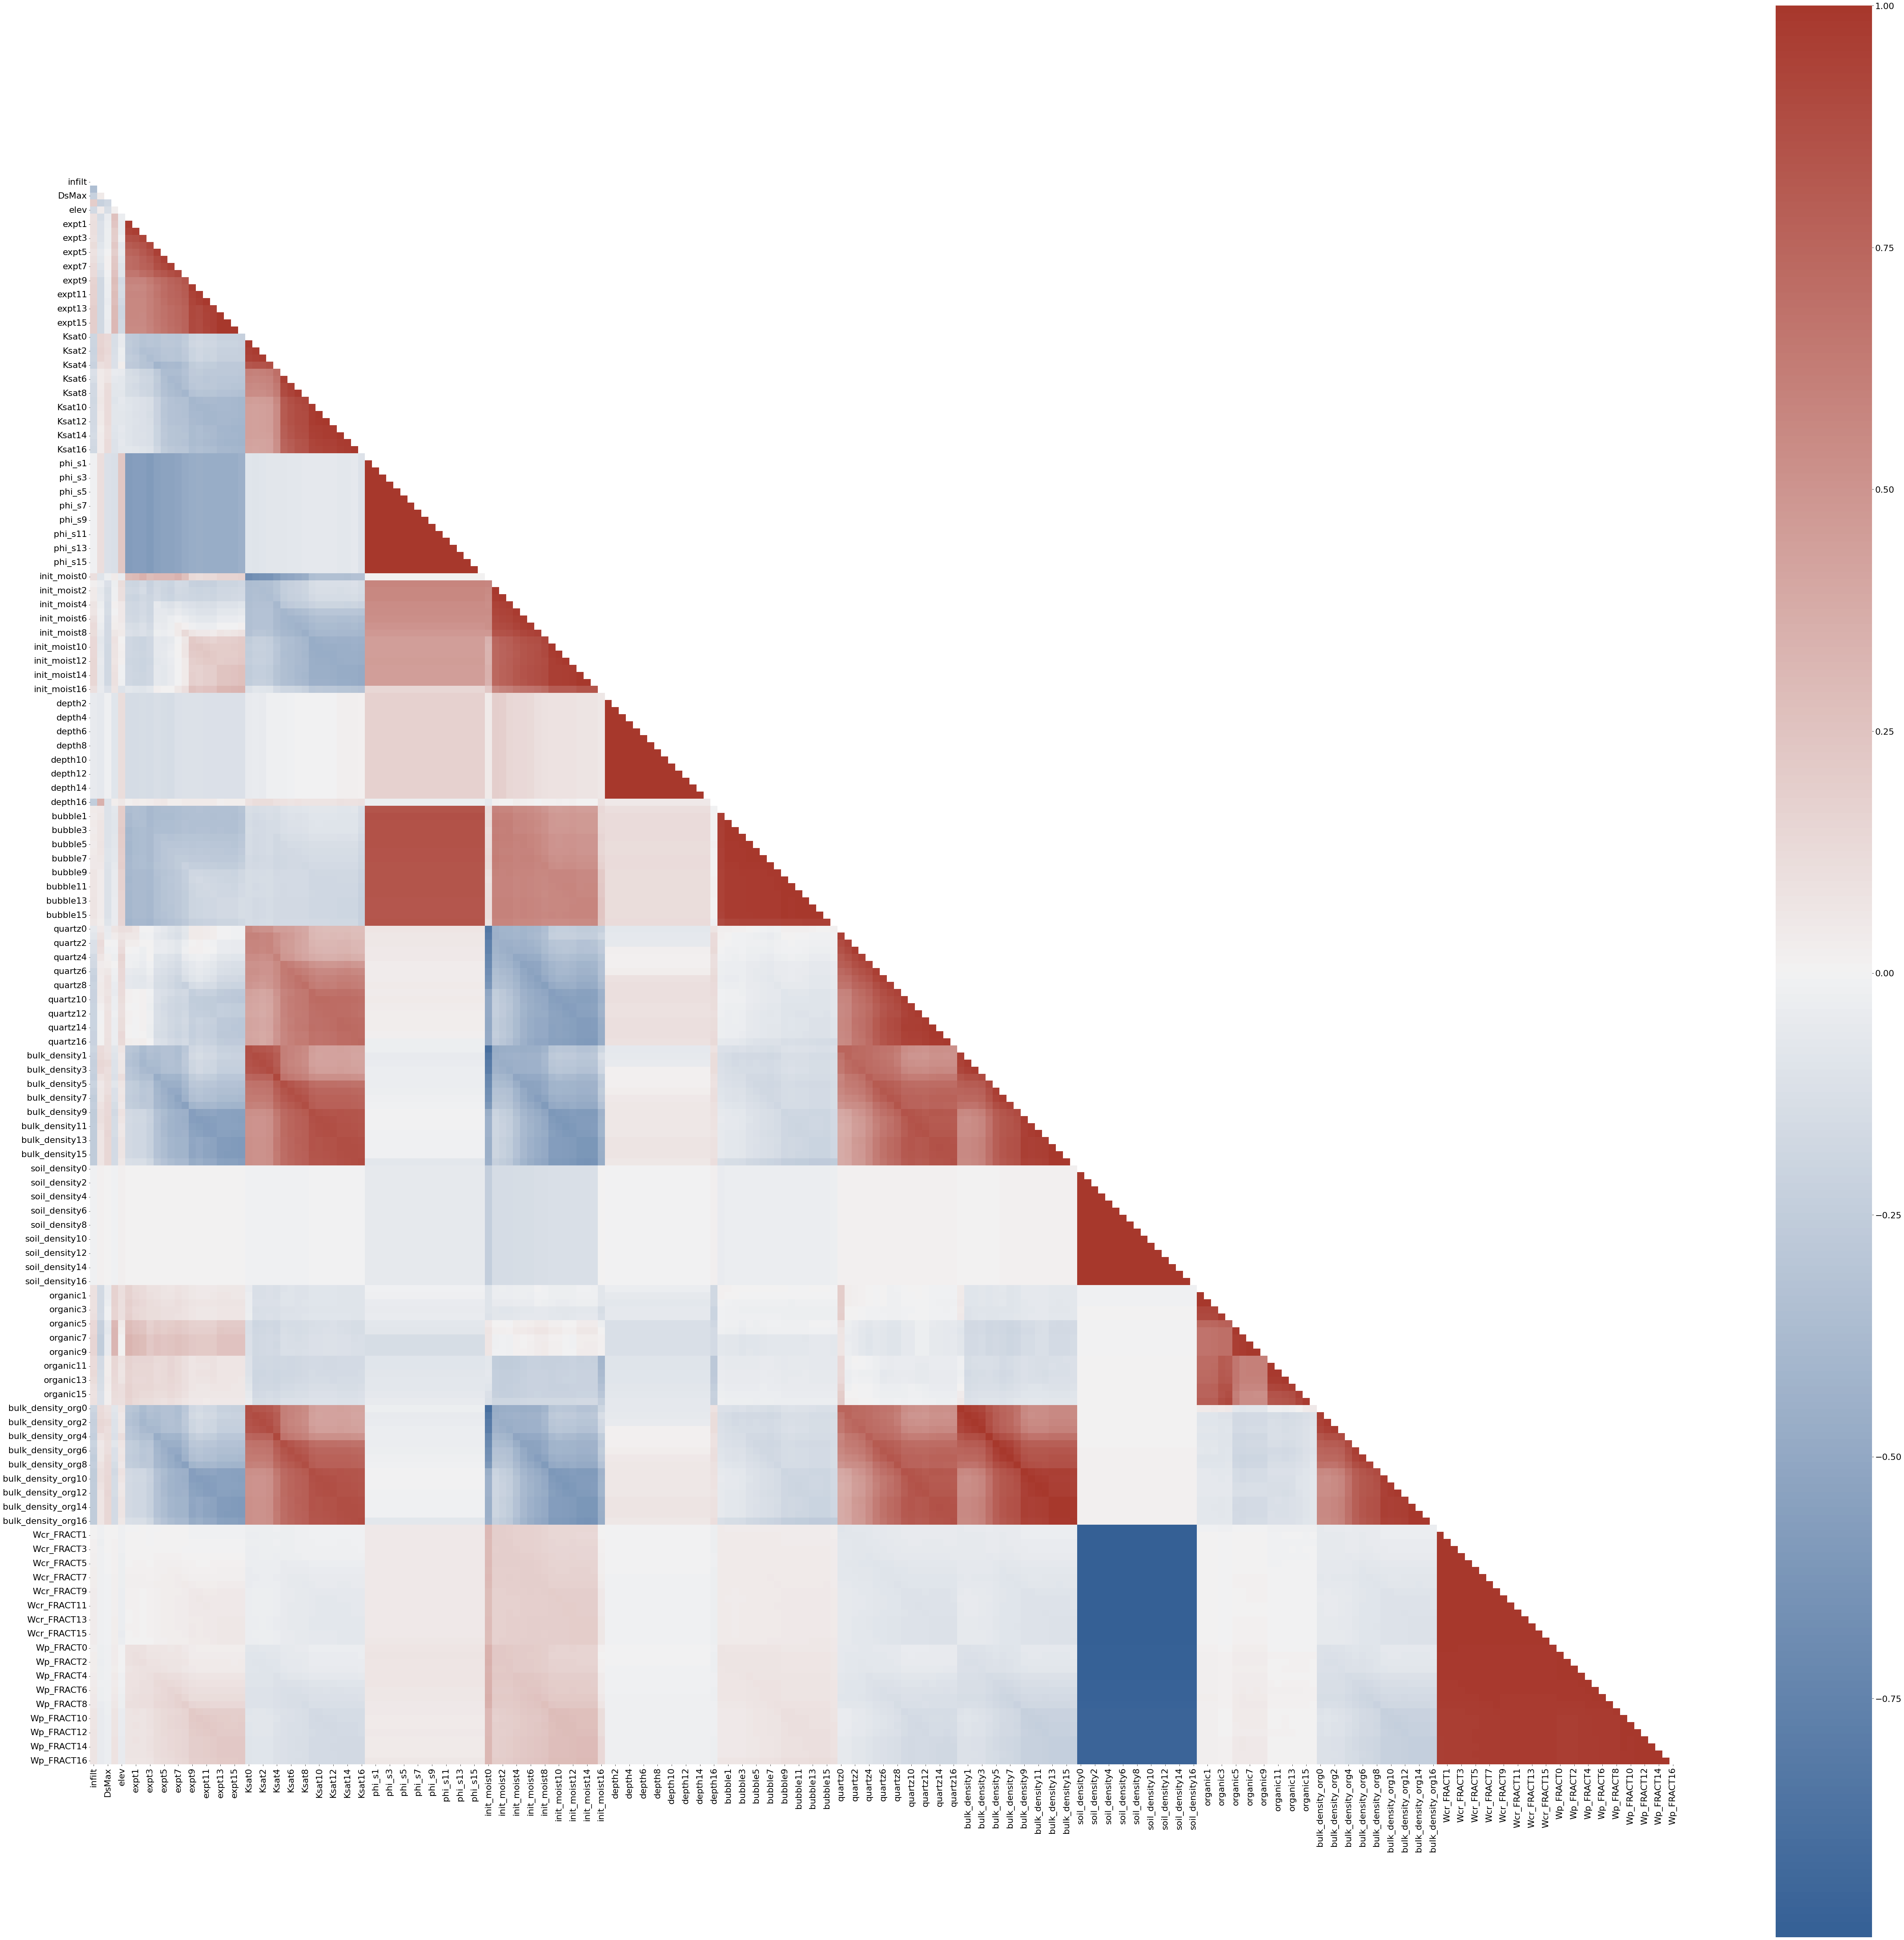

In [86]:
# Check pairwise correlations between variables

matrix = soil_data_sel.corr()

mask = np.triu(np.ones_like(matrix, dtype=bool))
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

plt.figure(figsize=(90,90))
_ = sns.heatmap(matrix, mask = mask, square=True, center=0, cmap = cmap)

In [87]:
# Corr: Automatic selection of columns to drop

corr_factors = get_correlated_factors(soil_data_sel, 0.5)

In [88]:
layered_factor_keys = ['expt', 'Ksat', 'phi_s', 'init_moist', 'depth', 'bubble', 'quartz', 'bulk_density_org', 'soil_density', 'organic', 'Wcr_FRACT', 'Wp_FRACT', 'bulk_density']

to_drop = []

for layered_factor_key in layered_factor_keys:
    # print(f'For: {layered_factor_key}')
    
    if layered_factor_key == 'depth':
        first_factor = layered_factor_key+'1'
    else:
        first_factor = layered_factor_key+'0'
    
    cur_factors = [factor for factor in corr_factors[first_factor].index if layered_factor_key in factor]
    to_drop = to_drop + cur_factors
    # print(cur_factors)
    # print(corr_factors[first_factor].loc[cur_factors])

to_drop = to_drop[:-17]

print(len(to_drop))

189


In [89]:
soil_data_sel = soil_data_sel.drop(to_drop, axis=1)
soil_data_sel.describe()

infilt           Ds        DsMax           Ws         elev  \
count  4834.000000  4834.000000  4834.000000  4834.000000  4834.000000   
mean      0.232173     0.361974    10.993550     0.546264   644.029802   
std       0.078255     0.259190     6.538623     0.250149   431.957924   
min       0.014946     0.032024     0.169521     0.066507     1.000000   
25%       0.194178     0.100000     7.300970     0.370905   302.500511   
50%       0.260755     0.341642    10.000000     0.536874   599.530487   
75%       0.297822     0.583856    17.145200     0.750000   864.234497   
max       0.300000     0.995996    29.989600     0.994086  3408.639890   

             expt0        Ksat0        Ksat9       Ksat10       Ksat11  ...  \
count  4834.000000  4834.000000  4834.000000  4834.000000  4834.000000  ...   
mean     11.464688   635.916976   621.978038   620.943760   623.132645  ...   
std       2.734812   521.781973   778.236955   791.355299   793.278230  ...   
min       3.374773    41.528100    41.528100    41.528100    41.528100  ...   
25%      10.197200   285.541600   129.828500   129.119900   129.119900  ...   
50%      10.898000   484.260100   355.781550   317.721400   317.721400  ...   
75%      12.842600   893.956100   893.956100   893.956100   893.956100  ...   
max      22.745500  5359.058100  4935.253400  4935.253400  4935.253400  ...   

            depth1      depth16      bubble0      quartz0  bulk_density0  \
count  4834.000000  4834.000000  4834.000000  4834.000000    4834.000000   
mean      0.132692     1.524073     9.028913     0.389983    1483.554259   
std       0.298411     0.774934     4.506810     0.221752     123.394352   
min       0.005000     0.011411     6.830250     0.030000    1187.478300   
25%       0.073100     1.122320     7.611000     0.212000    1401.469100   
50%       0.100000     1.609280     7.895900     0.335000    1457.639500   
75%       0.100000     2.031600     8.624600     0.470000    1560.609400   
max       2.042340     2.994340    49.780700     0.989000    2062.028100   

       soil_density0     organic0  bulk_density_org0   Wcr_FRACT0    Wp_FRACT0  
count    4834.000000  4834.000000        4834.000000  4834.000000  4834.000000  
mean     2649.745315     0.052460        1483.554259     0.473558     0.243669  
std        17.693850     0.127508         123.394352     0.826989     0.400428  
min      1419.800000     0.000000        1187.478300     0.262400     0.113400  
25%      2650.000000     0.013509        1401.469100     0.433978     0.215700  
50%      2650.000000     0.024795        1457.639500     0.482800     0.226400  
75%      2650.000000     0.043605        1560.609400     0.503300     0.252400  
max      2650.009860     0.991800        2062.028100    57.757400    27.768000  

[8 rows x 36 columns]

In [90]:
soil_data_sel.columns

Index(['infilt', 'Ds', 'DsMax', 'Ws', 'elev', 'expt0', 'Ksat0', 'Ksat9',
       'Ksat10', 'Ksat11', 'Ksat12', 'Ksat13', 'Ksat14', 'Ksat15', 'Ksat16',
       'phi_s0', 'init_moist0', 'init_moist8', 'init_moist9', 'init_moist10',
       'init_moist11', 'init_moist12', 'init_moist13', 'init_moist14',
       'init_moist15', 'init_moist16', 'depth1', 'depth16', 'bubble0',
       'quartz0', 'bulk_density0', 'soil_density0', 'organic0',
       'bulk_density_org0', 'Wcr_FRACT0', 'Wp_FRACT0'],
      dtype='object')

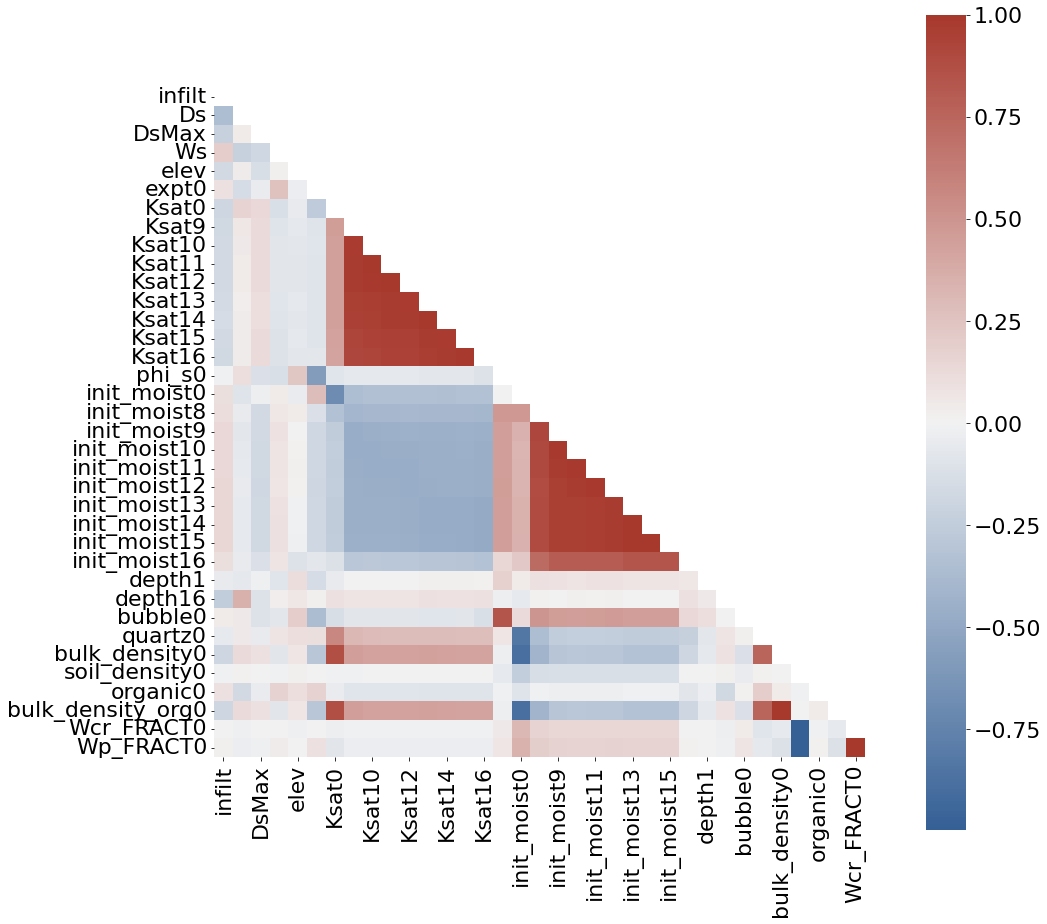

In [91]:
# Check for correlations again

matrix = soil_data_sel.corr()

mask = np.triu(np.ones_like(matrix, dtype=bool))
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

plt.figure(figsize=(15,15))
_ = sns.heatmap(matrix, mask = mask, square=True, center=0, cmap = cmap)

In [92]:
corr_factors = get_correlated_factors(soil_data_sel, 0.5)

In [93]:
layered_factor_keys = ['Ksat', 'init_moist']

to_drop = []

for layered_factor_key in layered_factor_keys:
    print(f'For: {layered_factor_key}')
    
    if layered_factor_key == 'init_moist':
        first_factor = layered_factor_key+'8'
    else:
        first_factor = layered_factor_key+'10'
    
    cur_factors = [factor for factor in corr_factors[first_factor].index if layered_factor_key in factor]
    to_drop = to_drop + cur_factors
    print(cur_factors)
    # print(corr_factors[first_factor].loc[cur_factors])

# print(len(to_drop))

For: Ksat
['Ksat9', 'Ksat11', 'Ksat12', 'Ksat13', 'Ksat14', 'Ksat15', 'Ksat16']
For: init_moist
['init_moist9', 'init_moist10', 'init_moist11', 'init_moist12', 'init_moist13', 'init_moist14', 'init_moist15', 'init_moist16']


In [94]:
soil_data_sel = soil_data_sel.drop(to_drop, axis=1)
soil_data_sel.describe()

infilt           Ds        DsMax           Ws         elev  \
count  4834.000000  4834.000000  4834.000000  4834.000000  4834.000000   
mean      0.232173     0.361974    10.993550     0.546264   644.029802   
std       0.078255     0.259190     6.538623     0.250149   431.957924   
min       0.014946     0.032024     0.169521     0.066507     1.000000   
25%       0.194178     0.100000     7.300970     0.370905   302.500511   
50%       0.260755     0.341642    10.000000     0.536874   599.530487   
75%       0.297822     0.583856    17.145200     0.750000   864.234497   
max       0.300000     0.995996    29.989600     0.994086  3408.639890   

             expt0        Ksat0       Ksat10       phi_s0  init_moist0  ...  \
count  4834.000000  4834.000000  4834.000000  4834.000000  4834.000000  ...   
mean     11.464688   635.916976   620.943760  -947.613984    11.525123  ...   
std       2.734812   521.781973   791.355299   208.844234     3.588671  ...   
min       3.374773    41.528100    41.528100  -999.000000     1.805600  ...   
25%      10.197200   285.541600   129.119900  -999.000000     8.843300  ...   
50%      10.898000   484.260100   317.721400  -999.000000    12.137700  ...   
75%      12.842600   893.956100   893.956100  -999.000000    13.544400  ...   
max      22.745500  5359.058100  4935.253400   -99.000000    71.933000  ...   

            depth1      depth16      bubble0      quartz0  bulk_density0  \
count  4834.000000  4834.000000  4834.000000  4834.000000    4834.000000   
mean      0.132692     1.524073     9.028913     0.389983    1483.554259   
std       0.298411     0.774934     4.506810     0.221752     123.394352   
min       0.005000     0.011411     6.830250     0.030000    1187.478300   
25%       0.073100     1.122320     7.611000     0.212000    1401.469100   
50%       0.100000     1.609280     7.895900     0.335000    1457.639500   
75%       0.100000     2.031600     8.624600     0.470000    1560.609400   
max       2.042340     2.994340    49.780700     0.989000    2062.028100   

       soil_density0     organic0  bulk_density_org0   Wcr_FRACT0    Wp_FRACT0  
count    4834.000000  4834.000000        4834.000000  4834.000000  4834.000000  
mean     2649.745315     0.052460        1483.554259     0.473558     0.243669  
std        17.693850     0.127508         123.394352     0.826989     0.400428  
min      1419.800000     0.000000        1187.478300     0.262400     0.113400  
25%      2650.000000     0.013509        1401.469100     0.433978     0.215700  
50%      2650.000000     0.024795        1457.639500     0.482800     0.226400  
75%      2650.000000     0.043605        1560.609400     0.503300     0.252400  
max      2650.009860     0.991800        2062.028100    57.757400    27.768000  

[8 rows x 21 columns]

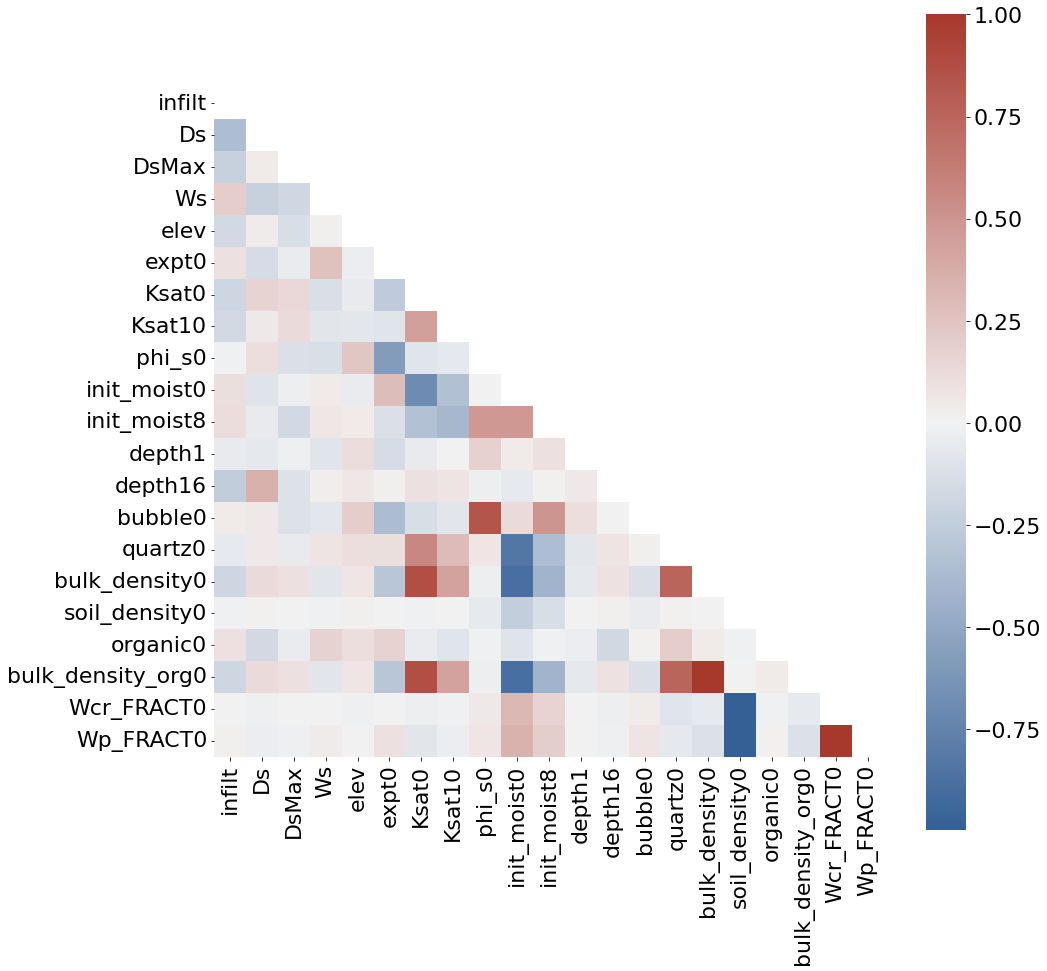

In [95]:
# Check for correlated factors a 3rd time
matrix = soil_data_sel.corr()

mask = np.triu(np.ones_like(matrix, dtype=bool))
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

plt.figure(figsize=(15,15))
_ = sns.heatmap(matrix, mask = mask, square=True, center=0, cmap = cmap)

In [96]:
# to_drop = identify_correlated(soil_data_sel, 0.5)
# to_drop
# # matrix
# matrix
# to_drop = ['Ksat10', 'Ksat11', 'Ksat12', 'quartz10', 'Wcr_FRACT9', 'Wp_FRACT9',
#        'Wp_FRACT10', 'Wp_FRACT11', 'Wp_FRACT12','organic5', 'organic6', 'organic7', 'organic8', 'organic9', 'quartz10', 'Wcr_FRACT3', 'Wcr_FRACT4', 'Wcr_FRACT5', 'Wcr_FRACT6',
#        'Wcr_FRACT7', 'Wcr_FRACT8', 'Wcr_FRACT9', 'Wcr_FRACT10', 'Wcr_FRACT11',
#        'Wcr_FRACT12', 'Wcr_FRACT13', 'Wcr_FRACT14', 'Wcr_FRACT15',
#        'Wcr_FRACT16' ]

In [97]:
corr_factors = get_correlated_factors(soil_data_sel, 0.5)

for cur_factor in corr_factors.keys():
    if len(corr_factors[cur_factor]) > 0:
        print(f'For {cur_factor}: ')
        print(corr_factors[cur_factor].index)

For expt0: 
Index(['phi_s0'], dtype='object')
For Ksat0: 
Index(['init_moist0', 'quartz0', 'bulk_density0', 'bulk_density_org0'], dtype='object')
For phi_s0: 
Index(['expt0', 'bubble0'], dtype='object')
For init_moist0: 
Index(['Ksat0', 'quartz0', 'bulk_density0', 'bulk_density_org0'], dtype='object')
For bubble0: 
Index(['phi_s0'], dtype='object')
For quartz0: 
Index(['Ksat0', 'init_moist0', 'bulk_density0', 'bulk_density_org0'], dtype='object')
For bulk_density0: 
Index(['Ksat0', 'init_moist0', 'quartz0', 'bulk_density_org0'], dtype='object')
For soil_density0: 
Index(['Wcr_FRACT0', 'Wp_FRACT0'], dtype='object')
For bulk_density_org0: 
Index(['Ksat0', 'init_moist0', 'quartz0', 'bulk_density0'], dtype='object')
For Wcr_FRACT0: 
Index(['soil_density0', 'Wp_FRACT0'], dtype='object')
For Wp_FRACT0: 
Index(['soil_density0', 'Wcr_FRACT0'], dtype='object')


In [98]:
to_drop = ['expt0', 'Ksat0', 'phi_s0', 'init_moist0', 'quartz0', 'bulk_density0', 'soil_density0', 'Wcr_FRACT0']
soil_data_sel = soil_data_sel.drop(to_drop, axis=1)
soil_data_sel.describe()

infilt           Ds        DsMax           Ws         elev  \
count  4834.000000  4834.000000  4834.000000  4834.000000  4834.000000   
mean      0.232173     0.361974    10.993550     0.546264   644.029802   
std       0.078255     0.259190     6.538623     0.250149   431.957924   
min       0.014946     0.032024     0.169521     0.066507     1.000000   
25%       0.194178     0.100000     7.300970     0.370905   302.500511   
50%       0.260755     0.341642    10.000000     0.536874   599.530487   
75%       0.297822     0.583856    17.145200     0.750000   864.234497   
max       0.300000     0.995996    29.989600     0.994086  3408.639890   

            Ksat10  init_moist8       depth1      depth16      bubble0  \
count  4834.000000  4834.000000  4834.000000  4834.000000  4834.000000   
mean    620.943760    11.316793     0.132692     1.524073     9.028913   
std     791.355299     6.597801     0.298411     0.774934     4.506810   
min      41.528100     0.584200     0.005000     0.011411     6.830250   
25%     129.119900     6.297200     0.073100     1.122320     7.611000   
50%     317.721400    10.003800     0.100000     1.609280     7.895900   
75%     893.956100    15.040300     0.100000     2.031600     8.624600   
max    4935.253400    71.933000     2.042340     2.994340    49.780700   

          organic0  bulk_density_org0    Wp_FRACT0  
count  4834.000000        4834.000000  4834.000000  
mean      0.052460        1483.554259     0.243669  
std       0.127508         123.394352     0.400428  
min       0.000000        1187.478300     0.113400  
25%       0.013509        1401.469100     0.215700  
50%       0.024795        1457.639500     0.226400  
75%       0.043605        1560.609400     0.252400  
max       0.991800        2062.028100    27.768000

In [99]:
# Change name of a column
soil_data_sel['b_den_org0'] = soil_data_sel['bulk_density_org0']
soil_data_sel = soil_data_sel.drop(['bulk_density_org0'], axis=1)

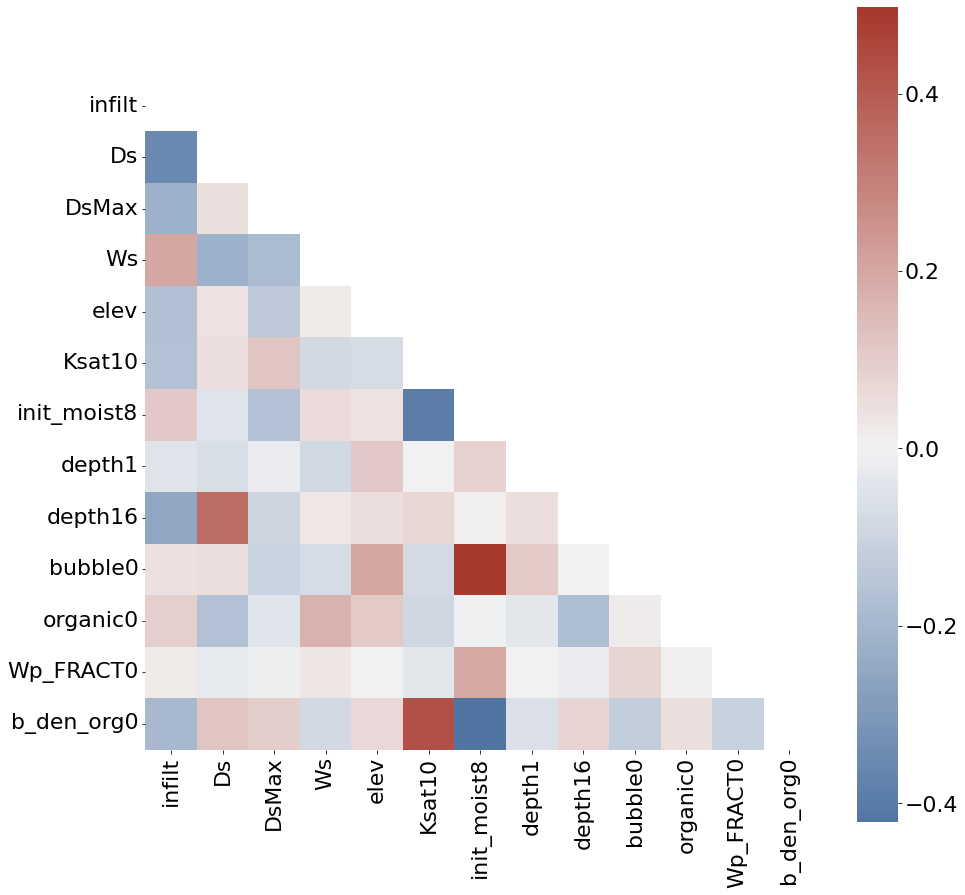

In [100]:
# Final set of features
matrix = soil_data_sel.corr()

mask = np.triu(np.ones_like(matrix, dtype=bool))
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

plt.figure(figsize=(15,15))
_ = sns.heatmap(matrix, mask = mask, square=True, center=0, cmap = cmap)
# plt.savefig('../fqsnow_paper/param_corr.png')

### Fitting to a model

In [101]:
X = soil_data_sel
y = np.array(cluster_ids_x)

# function arguments: (X, y, crit, bootstrap, max_feat, max_depth, min_leaf, n_est)

X_train, X_test, y_train, y_test, clf = random_forest_fitting(X, y, 'gini', True, 'sqrt', 9, 30, 50)

*************** Model Summary ***************
Classes:  [0 1 2 3 4 5]
No. of outputs:  1
No. of features:  13
No. of estimators:  50
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.7714581178903827
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       141
           1       0.93      0.85      0.89       111
           2       0.79      0.81      0.80       217
           3       0.66      0.59      0.62        74
           4       0.70      0.75      0.72       205
           5       0.75      0.75      0.75       219

    accuracy                           0.77       967
   macro avg       0.78      0.76      0.77       967
weighted avg       0.77      0.77      0.77       967

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.7693302301525731
              precis

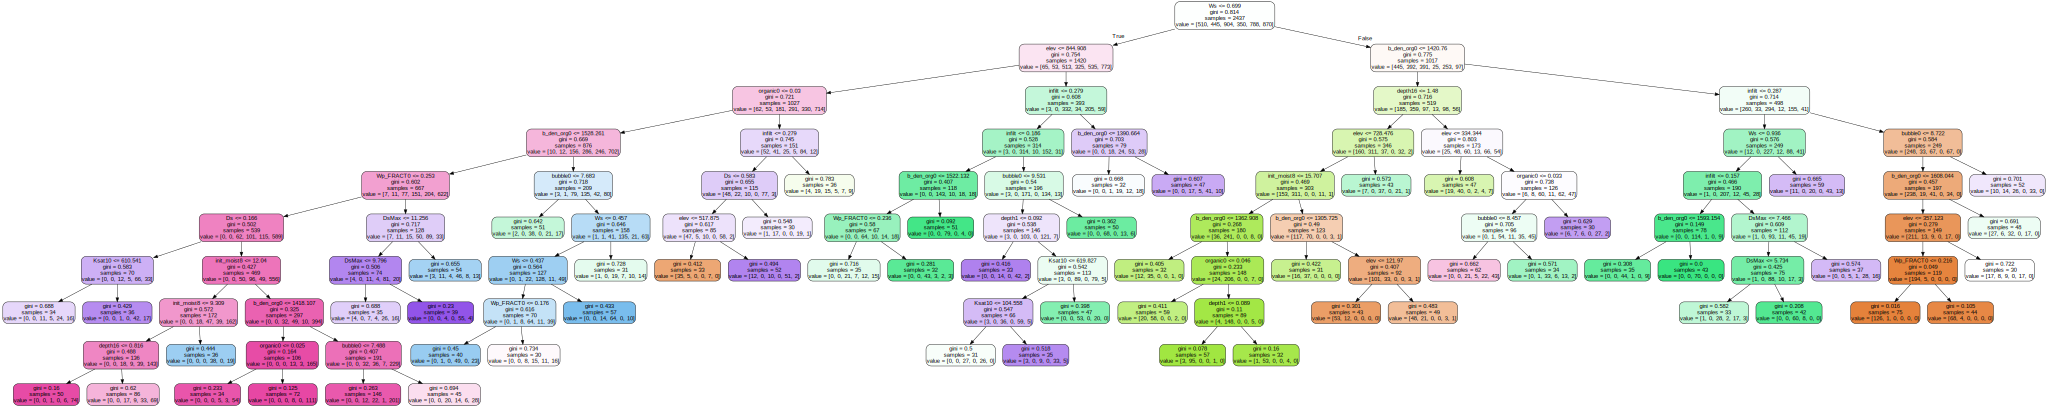

In [102]:
plt.rcParams.update({'font.size': 22})
# Use graphviz to plot the tree
dot_data = tree.export_graphviz(clf.estimators_[10], out_file=None, 
                            feature_names=X.columns,
                            filled=True, 
                            rounded=True, 
                            rotate=False
                           ) 
graph = graphviz.Source(dot_data)

graph

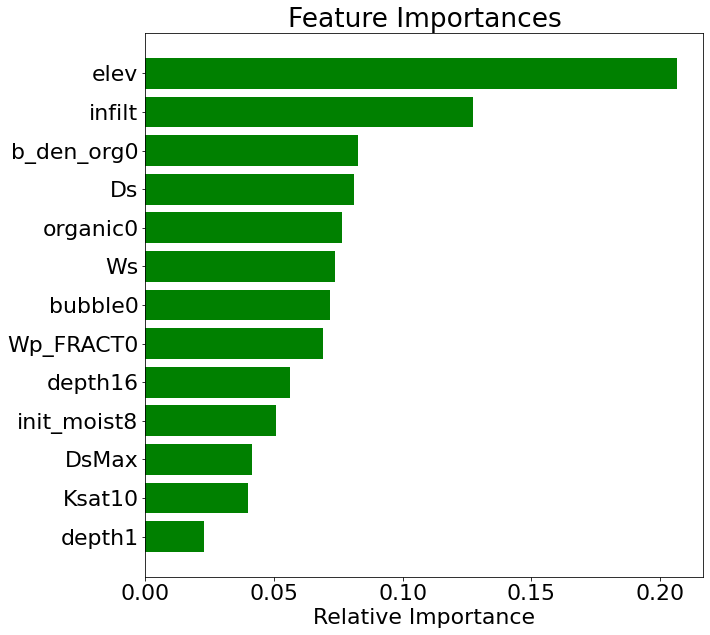

In [103]:
# Built in Feature importance analysis

importances = clf.feature_importances_
indices = np.argsort(importances)

features = soil_data_sel.columns

fig = plt.figure(num=None, figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

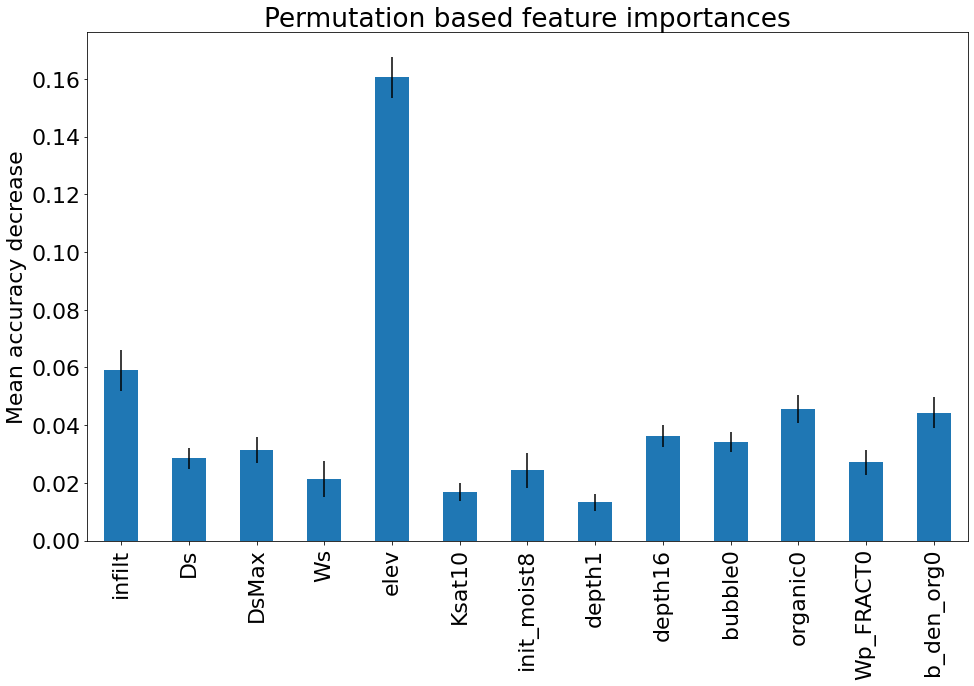

In [104]:
# permutation based feature importance

result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

# fig = plt.figure(num=None, figsize=(15,10))
fig, ax = plt.subplots(figsize=(14,10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Permutation based feature importances")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [105]:
# compute SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

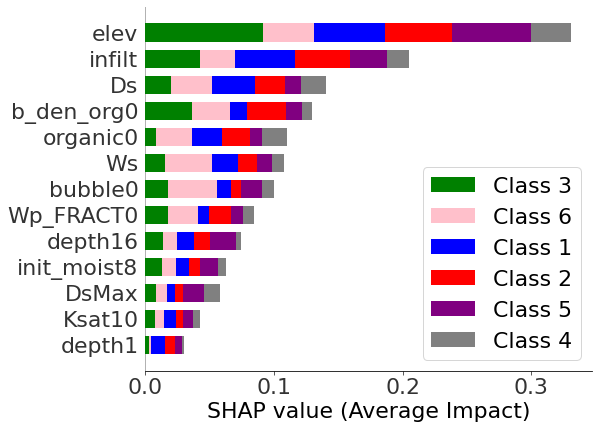

In [111]:
# shap.summary_plot function has an issue that it messes up the order of colors. For each run of the 
# k-means clustering algorithm (where cluster id's are assigned randomly to a set of gridcells), the color array
# of the getColor function needs to be modified (order of colors), so that class id matches with the original
# assigned color id in the proper order: ['blue', 'red', 'green', 'grey', 'purple', 'pink']. For example,
# Class 1 needs to be blue, Class 2 red, and so on ..

def getColor(i):
    color = ['green', 'pink', 'blue', 'red', 'purple', 'grey'] 
    return color[i]

shap.summary_plot(shap_values, X.values, plot_type="bar", color=getColor, class_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6'], feature_names = X.columns, show=False)
fig, ax = plt.gcf(), plt.gca()

# Modifying main plot parameters
ax.tick_params(labelsize=22)
ax.legend(fontsize=22)
ax.set_xlabel("SHAP value (Average Impact)", fontsize=22)

# plt.savefig('../fqsnow_paper/w2_aug/shap_values.png', bbox_inches='tight')
plt.show()

# shap.summary_plot(shap_values, X.values, plot_type="bar", color=getColor, feature_names = X.columns)

In [74]:
# shap.summary_plot(shap_values[0], X, max_display=8, feature_names = X.columns, show=False)
# fig, ax = plt.gcf(), plt.gca()

# fig.axes[-1].set_aspect('auto')
# plt.tight_layout()
# fig.axes[-1].set_box_aspect(50)

# ax.tick_params(labelsize=22)
# ax.set_xlabel("SHAP value", fontsize=22)

# cb_ax = fig.axes[1]
# cb_ax.tick_params(labelsize=22)
# cb_ax.set_ylabel("Feature value", fontsize=22)

# # plt.savefig('exports/cluster_1_shap.png')
# plt.show()

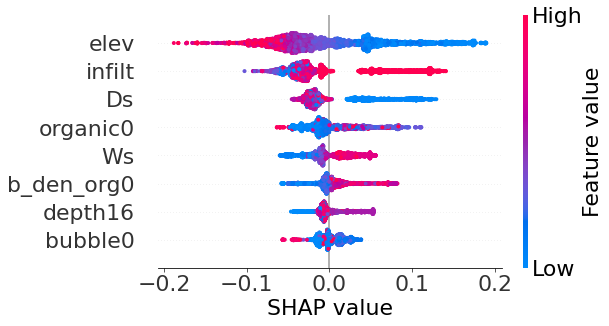

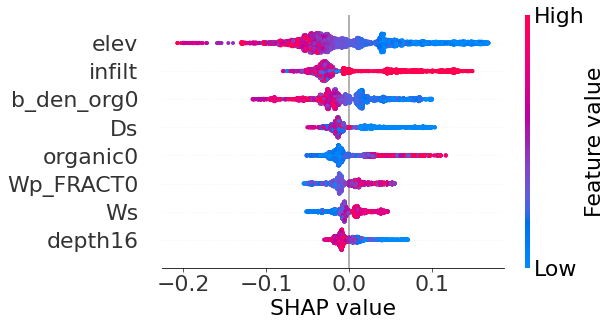

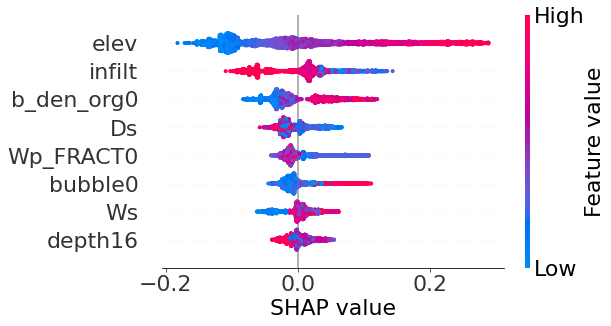

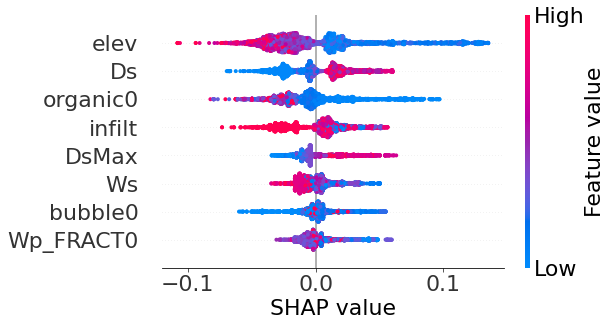

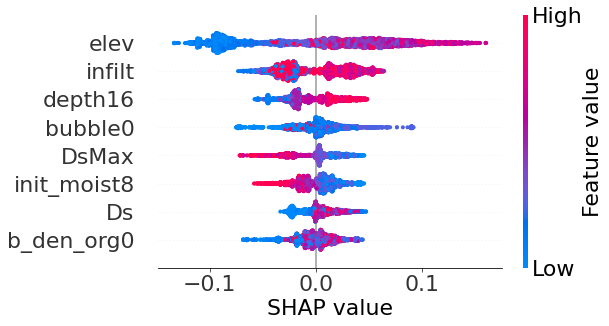

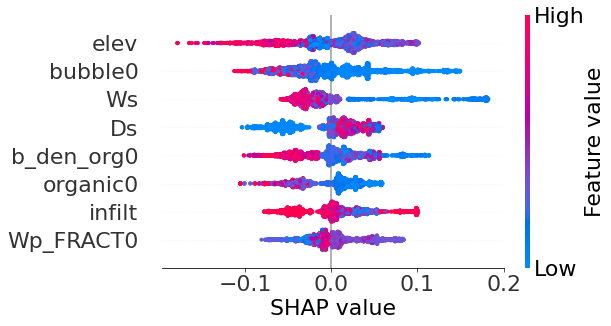

In [75]:
# shap.dependence_plot('infilt', shap_values[0], X, display_features=X_display)
# plt.rcParams.update({'font.size': 22})

def shap_indiv_plot(shap_values, cluster_id):
    shap.summary_plot(shap_values[cluster_id], X, max_display=8, feature_names = X.columns, show=False)
    fig, ax = plt.gcf(), plt.gca()

    fig.axes[-1].set_aspect('auto')
    plt.tight_layout()
    fig.axes[-1].set_box_aspect(50)

    ax.tick_params(labelsize=22)
    ax.set_xlabel("SHAP value", fontsize=22)

    cb_ax = fig.axes[1]
    cb_ax.tick_params(labelsize=22)
    cb_ax.set_ylabel("Feature value", fontsize=22)
    # plt.savefig('../fqsnow_paper/w2_aug/cl_'+str(cluster_id+1)+'_shap.png', bbox_inches='tight')
    plt.show()


shap_indiv_plot(shap_values, 0)
shap_indiv_plot(shap_values, 1)
shap_indiv_plot(shap_values, 2)
shap_indiv_plot(shap_values, 3)
shap_indiv_plot(shap_values, 4)
shap_indiv_plot(shap_values, 5)